In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from statistics import mean, variance, pstdev

Blood Glucose:
1. Combine training and test sets
2. Synchronize data for every 5 mins (data is from 0:0 to 23:55)
3. 是否instances数量与paper中对应
4. If 数量不对应，去除所有包含长度>1h missing values的天数
5. Linear interpolation

(no smoothing)

Meal:
1. Same synchronization with the glucose
2. 没有记录用0补，有记录的补碳水值

# Functions

In [4]:
def readData(location):
    df = pd.read_csv(location)
    df = df.drop('Unnamed: 0', axis=1)
    
    return df

In [5]:
# synchronize meal data

def dataSynchronizeMeal(data_frame, date_frame, time):
   
    # String -> Timestamp
    data_frame['ts'] = pd.to_datetime(data_frame['ts'], dayfirst=True)
    
    # remove data before time
    data_frame = data_frame[data_frame['ts'] >= time]
    
    value = []
    j = 0
    for i in range(len(date_frame)):
        diff = (date_frame['time'].iloc[i] - data_frame['ts'].iloc[j]).total_seconds()

        if diff < 300 and diff >= 0:

            value.append(data_frame['carbs'].iloc[j])
            if j == (len(data_frame) - 1):
                j = j 
            else:
                j = j + 1
                
        else:
            value.append(0)
            
    return value

In [6]:
# synchronize glucose, heart rate, skin temperature and gsr data

def dataSynchronize(data_frame, date_frame, time):
   
    # String -> Timestamp
    data_frame['ts'] = pd.to_datetime(data_frame['ts'], dayfirst=True)
    
    # remove data before time
    data_frame = data_frame[data_frame['ts'] >= time]
    
    value = []
    j = 0
    for i in range(len(date_frame)-1):
    
        while ((data_frame['ts'].iloc[j] < date_frame['time'].iloc[i])&(data_frame['ts'].iloc[j+1] < date_frame['time'].iloc[i])):
            j=j+1
        
        diff = (date_frame['time'].iloc[i] - data_frame['ts'].iloc[j]).total_seconds()
    
        if diff < 300 and diff >= 0:
            if data_frame['value'].iloc[j] == 0:
                value.append('NaN')
                j=j+1
            else:
                value.append(data_frame['value'].iloc[j])
                j=j+1
        
        else:
            value.append('NaN')
            
    return data_frame, value

In [44]:
# show all the feature values in one image

def showFeatures(data, patient_num):
    plt.figure(figsize=(30,8))
    plt.plot(data['time'], data['glucose_value'], label='glucose')
    plt.plot(data['time'], data['meal_value'], label='meal')
    plt.title(patient_num)
    plt.xlabel("time")
    plt.ylabel("value")
    plt.legend()

    #plt.show()
    plt.savefig('image/BG_meal.jpg')

In [8]:
# find each consecutive missing periods

def getMissing(data, feature):
    miss = []
    for k, v in data[data[feature] == 'NaN'].groupby((data[feature] != 'NaN').cumsum()):
        miss.append(v['time'].tolist())
    
    starting_time = []
    ending_time = []
    duration = []
    for i in range(len(miss)):
        starting_time.append(miss[i][0])
        ending_time.append(miss[i][-1])
        duration.append(len(miss[i]))
        
    df_miss = pd.DataFrame(list(zip(starting_time, ending_time, duration)), columns = ['start', 'end', 'duration'])
    
    return df_miss

In [50]:
def showMissing(data, data_nonmiss, feature):
    miss_index = []
    for k, v in data[data[feature] == 'NaN'].groupby((data[feature] != 'NaN').cumsum()):
        miss_index.append(v.index.tolist()) 

    miss_value = []
    miss_time = []
    for i in range(len(miss_index)):
        miss_value.append(data_nonmiss[feature][miss_index[i][0] : miss_index[i][-1]+1])
        miss_time.append(data_nonmiss['time'][miss_index[i][0] : miss_index[i][-1]+1])
        
    plt.figure(figsize=(30,8))
    plt.plot(data['time'], data[feature], label='blood glucose')
    plt.plot(data['time'], data['meal_value'], label='meal')
    for i in range(len(miss_value)):
        if i == 0:
            plt.plot(list(miss_time[i]), list(miss_value[i]), c='red', label='impuated blood glucose')
        else:
            plt.plot(list(miss_time[i]), list(miss_value[i]), c='red')
    plt.title(feature)
    plt.xlabel("time")
    plt.ylabel(feature)
    plt.legend()

    plt.savefig('image/BG_meal_imputed.jpg')

In [10]:
def getStatistics(dataframe):
    hyper = len(dataframe[dataframe['glucose_value'] >= 180])/len(dataframe)
    print('Hyper: {}'.format(hyper*100))

    tir = len(dataframe[(dataframe['glucose_value'] >= 70) & (dataframe['glucose_value'] < 180)])/len(dataframe)
    print('TIR: {}'.format(tir*100))

    l1_hypo = len(dataframe[(dataframe['glucose_value'] >= 54) & (dataframe['glucose_value'] < 70)])/len(dataframe)
    print('L1 Hypo: {}'.format(l1_hypo*100))

    l2_hypo = len(dataframe[dataframe['glucose_value'] < 54])/len(dataframe)
    print('L2 Hypo: {}'.format(l2_hypo*100))
    
    mean_value = mean(dataframe['glucose_value'].values.tolist())
    print('mean: {}'.format(mean_value))
    
    std_value = pstdev(dataframe['glucose_value'].values.tolist())
    print('standard deviation: {}'.format(std_value))
    
    return hyper, tir, l1_hypo, l2_hypo, mean_value, std_value

# Data exploration

In [11]:
df_559 = pd.read_csv('processed data/Imputation/559.csv')

In [12]:
df_559['glucose_value'].isna().sum()

1439

In [13]:
df_559_nonmiss = df_559.fillna(0)

In [14]:
def cal_miss_rate(df):
    zero = 0
    for i in range(len(df)):
          if df.iloc[:,1].values[i] == 0:
                zero = zero + 1
    print("zero is %d, count is %d, zero/count is %f" %(zero,len(df),(zero/len(df))*100))

In [15]:
cal_miss_rate(df_559_nonmiss)

zero is 1439, count is 14112, zero/count is 10.196995


# Patient 559

In [16]:
df_glucose_training_559 =  readData('data/training_1/559_training/data_glucose_level.csv')
df_glucose_test_559 =  readData('data/testing_1/559_testing/data_glucose_level.csv')
df_glucose_all_559 = pd.concat([df_glucose_training_559, df_glucose_test_559])
df_glucose_all_559 = df_glucose_all_559.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_559['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_559['ts'].iloc[-1]))

df_meal_training_559 =  readData('data/training_1/559_training/data_meal.csv')
df_meal_test_559 =  readData('data/testing_1/559_testing/data_meal.csv')
df_meal_all_559 = pd.concat([df_meal_training_559, df_meal_test_559])
df_meal_all_559 = df_meal_all_559.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_559['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_559['ts'].iloc[-1]))

The glucose data is recorded from 07-12-2021 01:17:00
The glucose data ends at 27-01-2022 23:38:00
The meal data is recorded from 07-12-2021 15:25:00
The meal data ends at 27-01-2022 17:00:00


In [17]:
len(df_meal_all_559)

179

In [18]:
date_new_559 = pd.date_range(start=datetime(2021, 12, 8, hour=0, minute=0), end=datetime(2022, 1, 26, hour=0, minute=0), freq='5min')
df_date_new_559 = pd.DataFrame(date_new_559, columns=['time'])

In [19]:
df_glucose_559, glucose_value_559 = dataSynchronize(df_glucose_all_559, df_date_new_559, '2021-12-7 23:55:00')

In [20]:
meal_value_559 = dataSynchronizeMeal(df_meal_all_559, df_date_new_559, '2021-12-7 23:55:00')

In [21]:
df_559 = pd.DataFrame(list(zip(date_new_559, glucose_value_559, meal_value_559)), columns=['time', 'glucose_value', 'meal_value'])

In [22]:
df_559['glucose_value'].iloc[0] = 343

C:\Users\wang\AppData\Local\Temp\ipykernel_16868\3631958082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_559['glucose_value'].iloc[0] = 343


In [23]:
df_559

time glucose_value  meal_value
0     2021-12-08 00:00:00           343           0
1     2021-12-08 00:05:00           343           0
2     2021-12-08 00:10:00           346           0
3     2021-12-08 00:15:00           346           0
4     2021-12-08 00:20:00           344           0
...                   ...           ...         ...
14107 2022-01-25 23:35:00           212           0
14108 2022-01-25 23:40:00           210           0
14109 2022-01-25 23:45:00           205           0
14110 2022-01-25 23:50:00           200           0
14111 2022-01-25 23:55:00           194           0

[14112 rows x 3 columns]

In [205]:
df_559['date'] = df_559['time'].apply(lambda x: x.date())
dates = df_559['date'].unique()
daily_data = []
for date in dates:
    daily_data.append(df_559[df_559['date'] == date]['glucose_value'].values.tolist())

In [206]:
# the number of instances
len(daily_data)

49

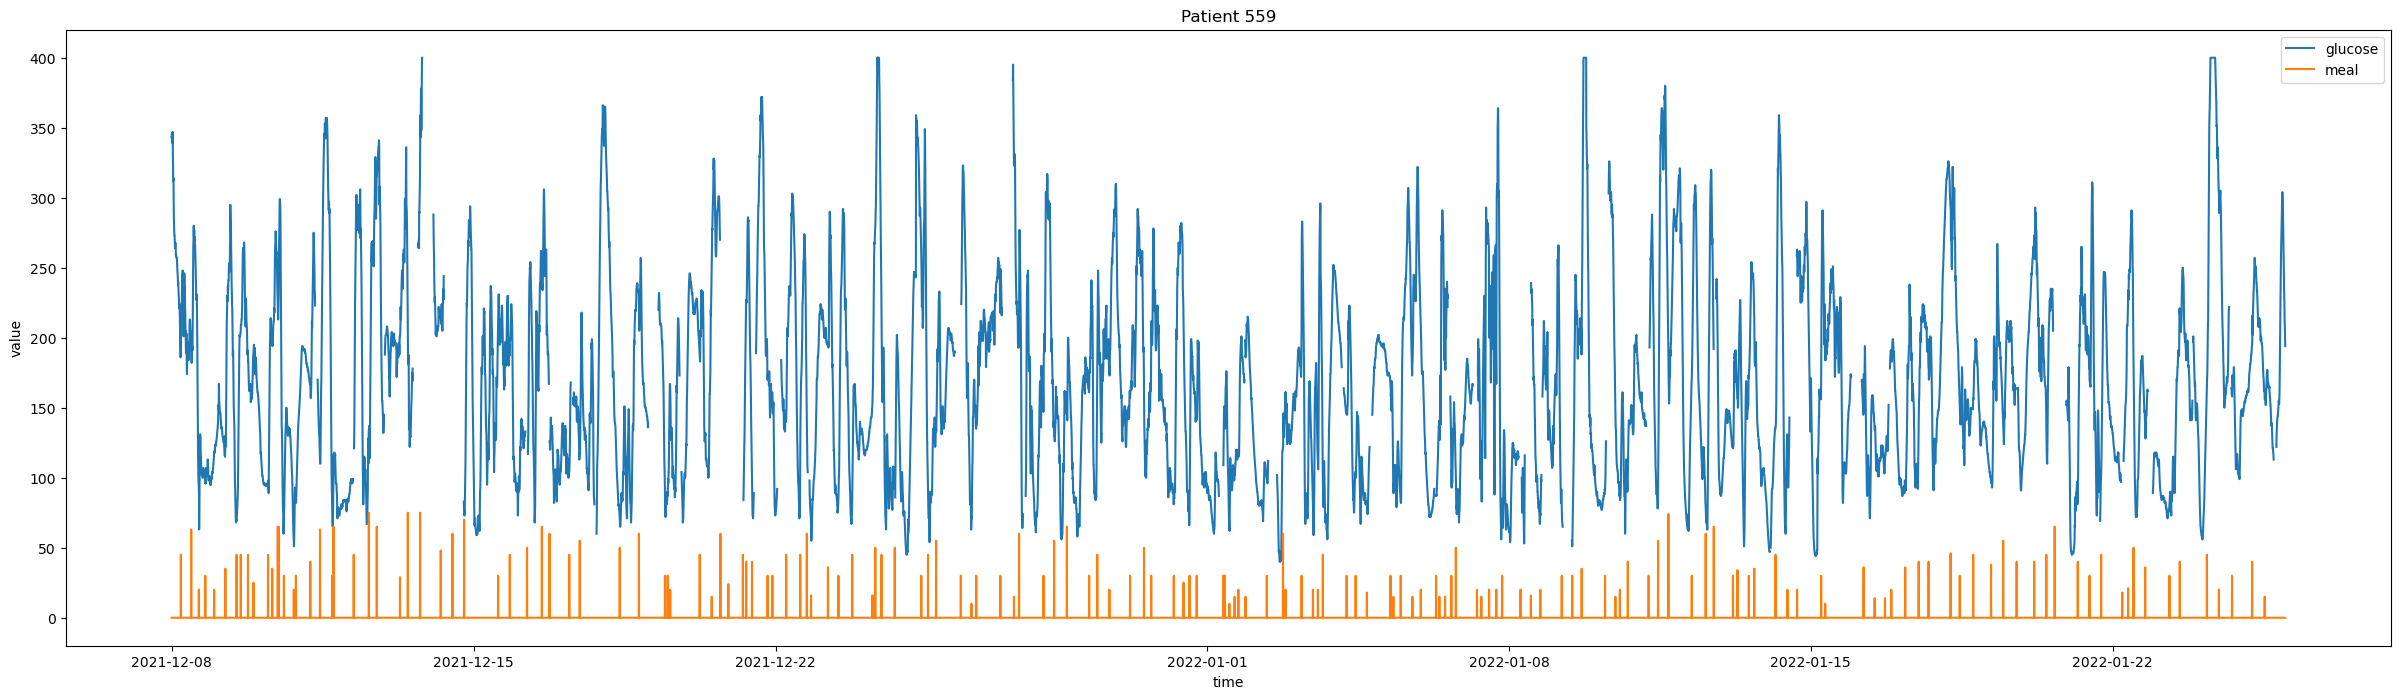

In [48]:
showFeatures(df_559, 'Patient 559')

In [38]:
df_nonmiss_559 = pd.DataFrame(list(zip(df_559['time'], df_559['glucose_value'].astype(float).interpolate(),meal_value_559)), columns=['time', 'glucose_value', 'meal_value'])

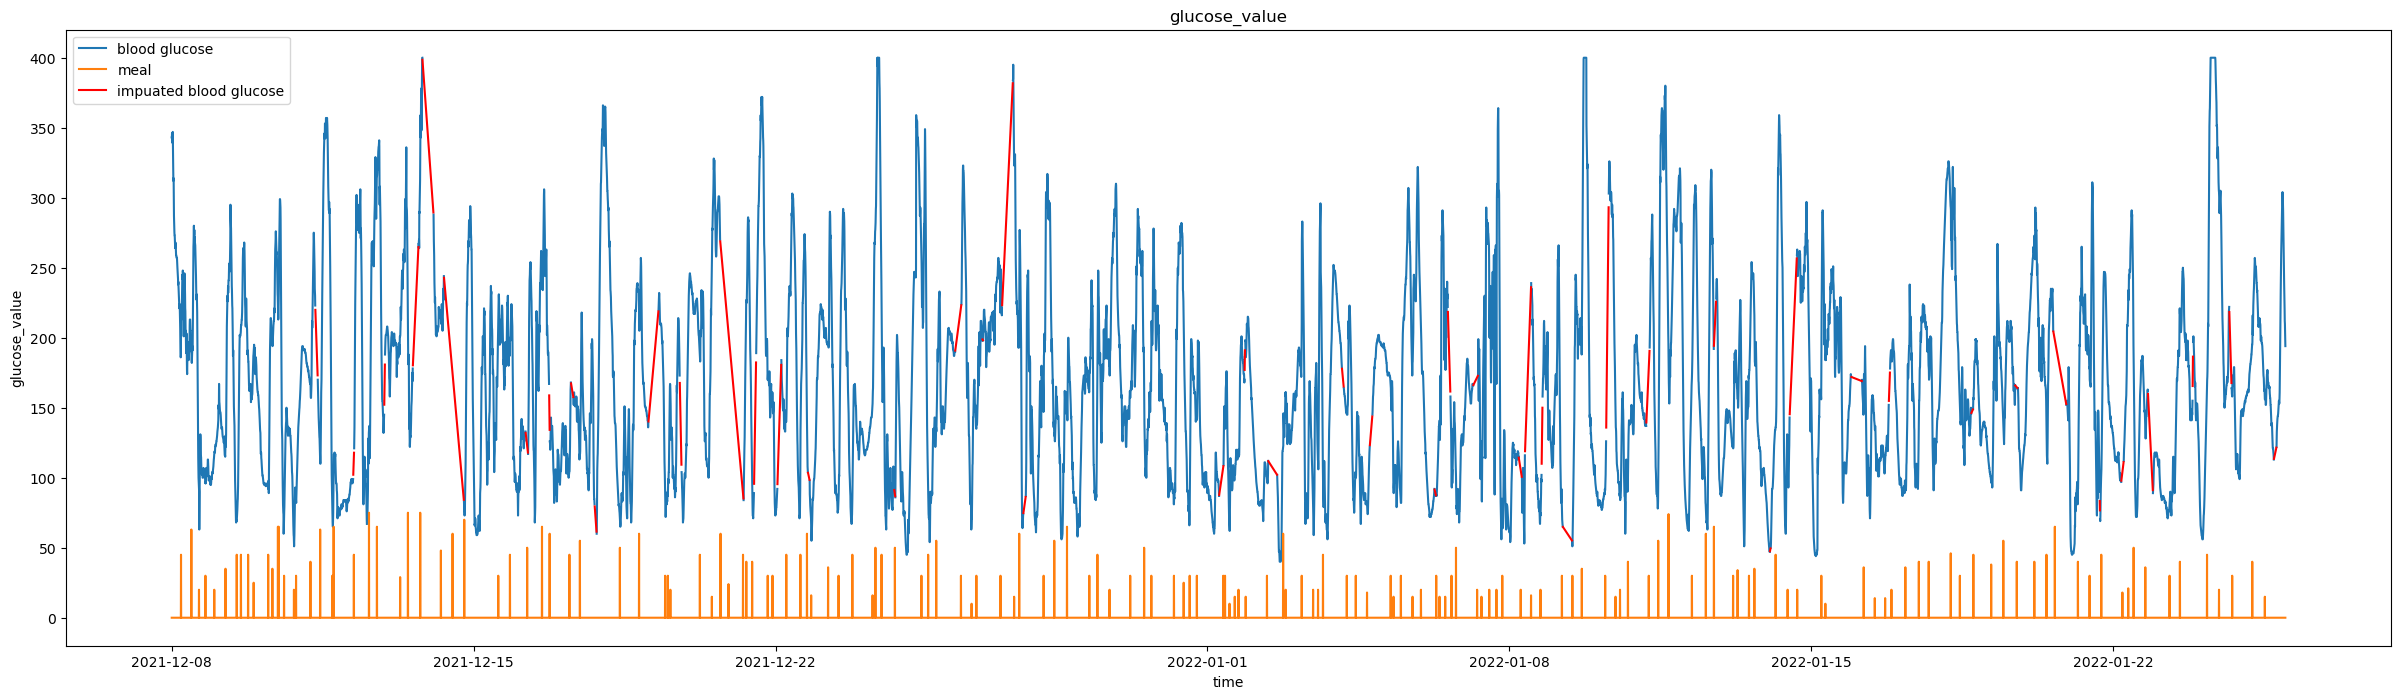

In [51]:
showMissing(df_559, df_nonmiss_559, 'glucose_value')

In [351]:
df_nonmiss_559.to_csv('processed data/GAN/559.csv', index=False)

In [137]:
for i in range(len(daily_data)):
    if len(daily_data[i]) != 288:
        print(i)

In [353]:
df_glucose_miss_559 = getMissing(df_559, 'glucose_value')
df_glucose_miss_559[df_glucose_miss_559['duration'] > 12]

start                 end  duration
0  2021-12-11 07:55:00 2021-12-11 09:10:00        16
4  2021-12-13 14:10:00 2021-12-13 17:15:00        38
5  2021-12-13 19:30:00 2021-12-14 01:35:00        74
6  2021-12-14 07:30:00 2021-12-14 18:30:00       133
7  2021-12-16 04:55:00 2021-12-16 06:10:00        16
9  2021-12-17 06:10:00 2021-12-17 07:25:00        16
10 2021-12-17 19:20:00 2021-12-17 20:20:00        13
11 2021-12-19 01:15:00 2021-12-19 06:45:00        67
13 2021-12-20 17:10:00 2021-12-21 06:05:00       156
14 2021-12-21 12:00:00 2021-12-21 13:05:00        14
15 2021-12-22 01:00:00 2021-12-22 03:05:00        26
18 2021-12-26 03:55:00 2021-12-26 07:15:00        41
20 2021-12-27 06:00:00 2021-12-27 11:55:00        72
21 2021-12-27 17:50:00 2021-12-27 19:05:00        16
22 2022-01-01 06:45:00 2022-01-01 09:05:00        29
24 2022-01-02 10:05:00 2022-01-02 14:55:00        59
26 2022-01-04 18:35:00 2022-01-04 19:55:00        17
28 2022-01-06 14:00:00 2022-01-06 15:20:00        17
29 2022-01-07 04:10:00 2022-01-07 06:40:00        31
30 2022-01-08 05:25:00 2022-01-08 07:05:00        21
31 2022-01-08 08:55:00 2022-01-08 12:15:00        41
33 2022-01-09 06:00:00 2022-01-09 11:00:00        61
34 2022-01-10 06:05:00 2022-01-10 07:25:00        17
35 2022-01-11 04:25:00 2022-01-11 06:10:00        22
36 2022-01-12 18:00:00 2022-01-12 19:10:00        15
38 2022-01-14 12:10:00 2022-01-14 16:05:00        48
39 2022-01-15 22:30:00 2022-01-16 04:15:00        70
42 2022-01-19 17:40:00 2022-01-19 18:50:00        15
43 2022-01-20 14:50:00 2022-01-20 22:00:00        87
45 2022-01-22 04:40:00 2022-01-22 05:55:00        16
46 2022-01-22 19:30:00 2022-01-22 22:10:00        33
48 2022-01-24 16:45:00 2022-01-24 17:55:00        15
49 2022-01-25 17:35:00 2022-01-25 18:55:00        17

In [455]:
hyper_559, tir_559, l1_559, l2_559, mean_559, std_559 = getStatistics(df_nonmiss_559)

Hyper: 40.75255102040816
TIR: 55.817743764172334
L1 Hypo: 2.6927437641723357
L2 Hypo: 0.7369614512471655
mean: 169.48324121315193
standard deviation: 70.31397924995149


# Patient 563

In [176]:
df_glucose_training_563 =  readData('data/training_1/563_training/data_glucose_level.csv')
df_glucose_test_563 =  readData('data/testing_1/563_testing/data_glucose_level.csv')
df_glucose_all_563 = pd.concat([df_glucose_training_563, df_glucose_test_563])
df_glucose_all_563 = df_glucose_all_563.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_563['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_563['ts'].iloc[-1]))

df_meal_training_563 =  readData('data/training_1/563_training/data_meal.csv')
df_meal_test_563 =  readData('data/testing_1/563_testing/data_meal.csv')
df_meal_all_563 = pd.concat([df_meal_training_563, df_meal_test_563])
df_meal_all_563 = df_meal_all_563.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_563['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_563['ts'].iloc[-1]))

The glucose data is recorded from 13-09-2021 12:33:00
The glucose data ends at 07-11-2021 08:13:00
The meal data is recorded from 14-09-2021 06:02:00
The meal data ends at 07-11-2021 18:29:00


In [52]:
df_skin_training_563 =  readData('data/training_1/563_training/data_basis_skin_temperature.csv')
df_skin_test_563 = readData('data/testing_1/563_testing/data_basis_skin_temperature.csv')
df_skin_all_563 = pd.concat([df_skin_training_563, df_skin_test_563])
df_skin_all_563 = df_skin_all_563.reset_index(drop=True)
print('The skin temporature data is recorded from {}'.format(df_skin_all_563['ts'][0]))
print('The skin temporature data ends at {}'.format(df_skin_all_563['ts'].iloc[-1]))

The skin temporature data is recorded from 17-09-2021 09:30:00
The skin temporature data ends at 07-11-2021 23:57:00


In [177]:
len(df_meal_all_563)

156

In [68]:
date_new_563 = pd.date_range(start=datetime(2021, 9, 18, hour=0, minute=0), end=datetime(2021, 11, 7, hour=0, minute=0), freq='5min')
df_date_new_563 = pd.DataFrame(date_new_563, columns=['time'])

In [69]:
df_skin_563, skin_value_563 = dataSynchronize(df_skin_all_563, df_date_new_563, '2021-9-17 23:58:00')

In [ ]:
df_glucose_563, glucose_value_563 = dataSynchronize(df_glucose_all_563, df_date_new_563, '2021-9-13 23:55:00')

In [215]:
meal_value_563 = dataSynchronizeMeal(df_meal_all_563, df_date_new_563, '2021-9-13 23:55:00')

In [216]:
df_563 = pd.DataFrame(list(zip(date_new_563, glucose_value_563, meal_value_563)), columns=['time', 'glucose_value', 'meal_value'])

In [70]:
df_563 = pd.DataFrame(list(zip(date_new_563, skin_value_563)), columns=['time', 'skin_temp_value'])

In [74]:
df_563.to_csv('skin_temp.csv', index=False)

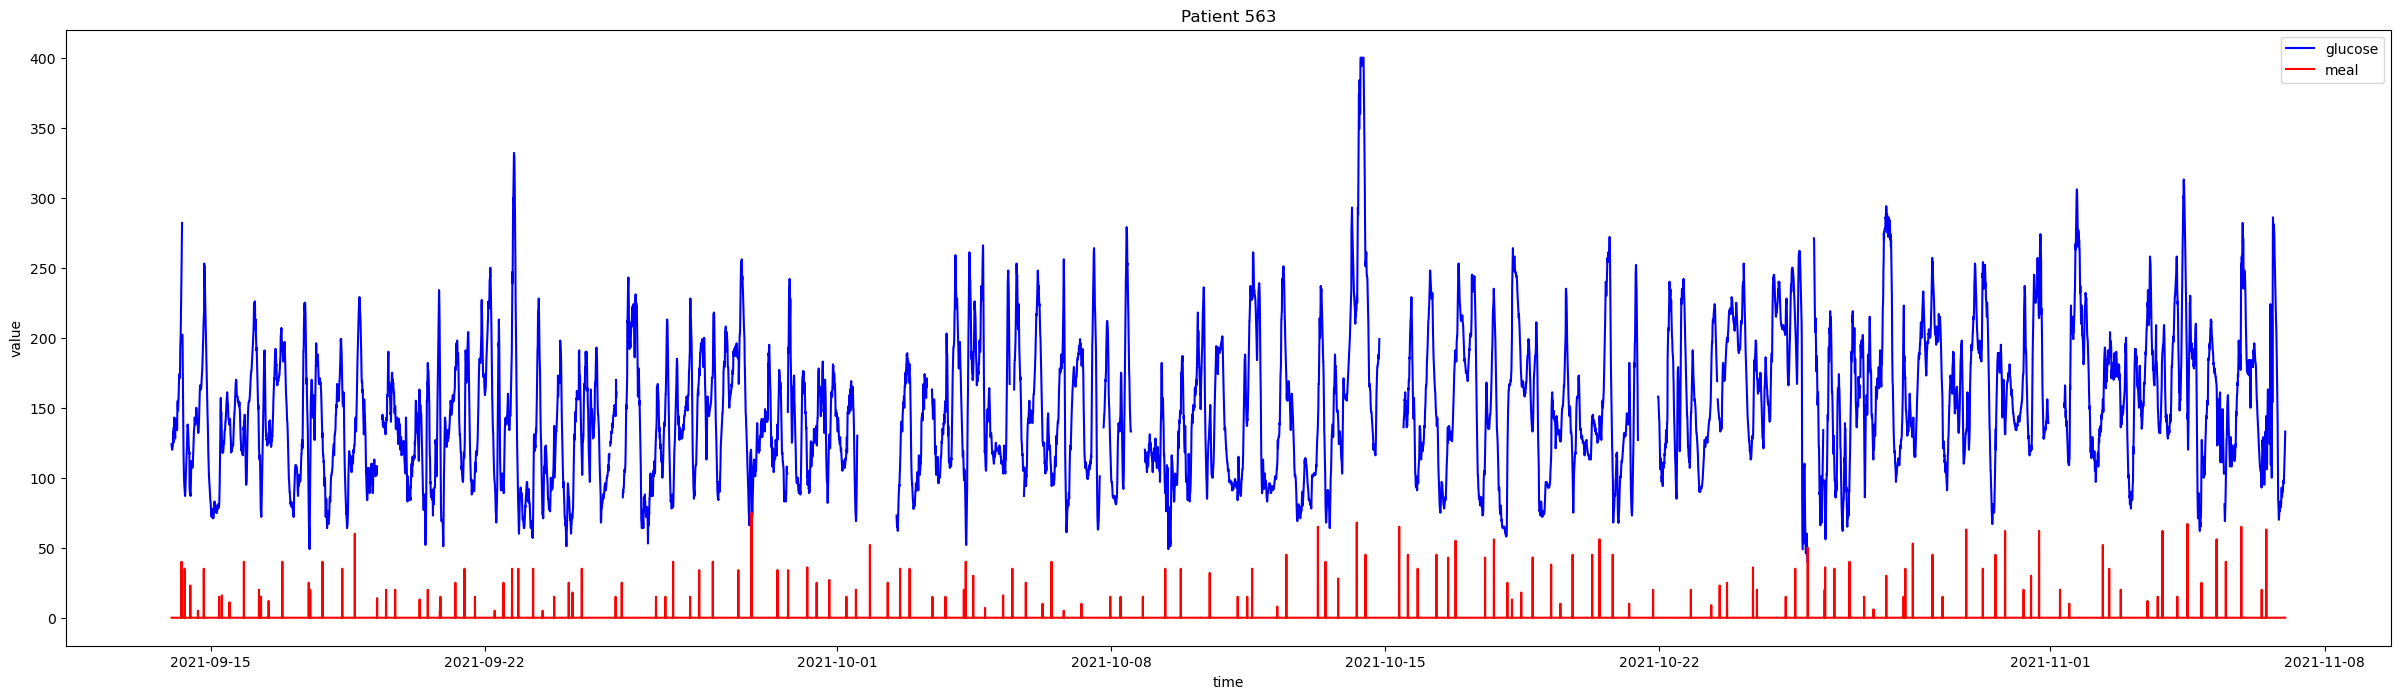

In [218]:
showFeatures(df_563, 'Patient 563')

In [219]:
df_563['date'] = df_563['time'].apply(lambda x: x.date())
dates = df_563['date'].unique()
daily_data = []
for date in dates:
    daily_data.append(df_563[df_563['date'] == date]['glucose_value'].values.tolist())

In [220]:
len(daily_data)

54

In [221]:
df_nonmiss_563 = pd.DataFrame(list(zip(df_563['time'], df_563['glucose_value'].astype(float).interpolate(),meal_value_563)), columns=['time', 'glucose_value', 'meal_value'])

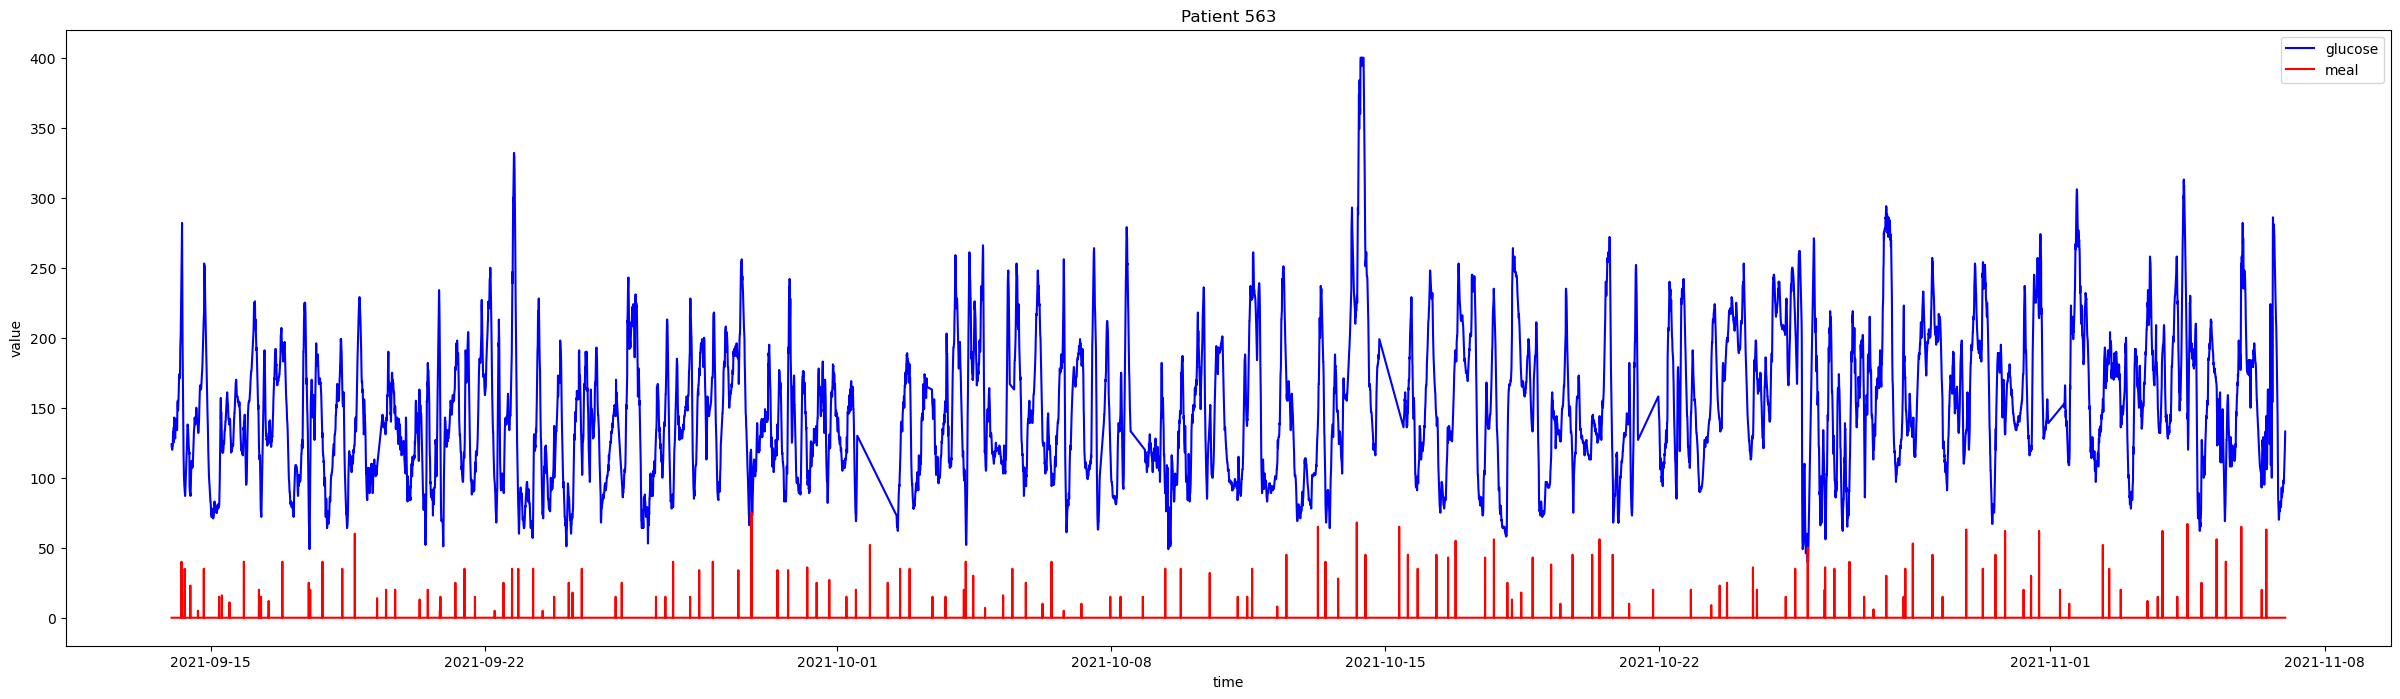

In [222]:
showFeatures(df_nonmiss_563, 'Patient 563')

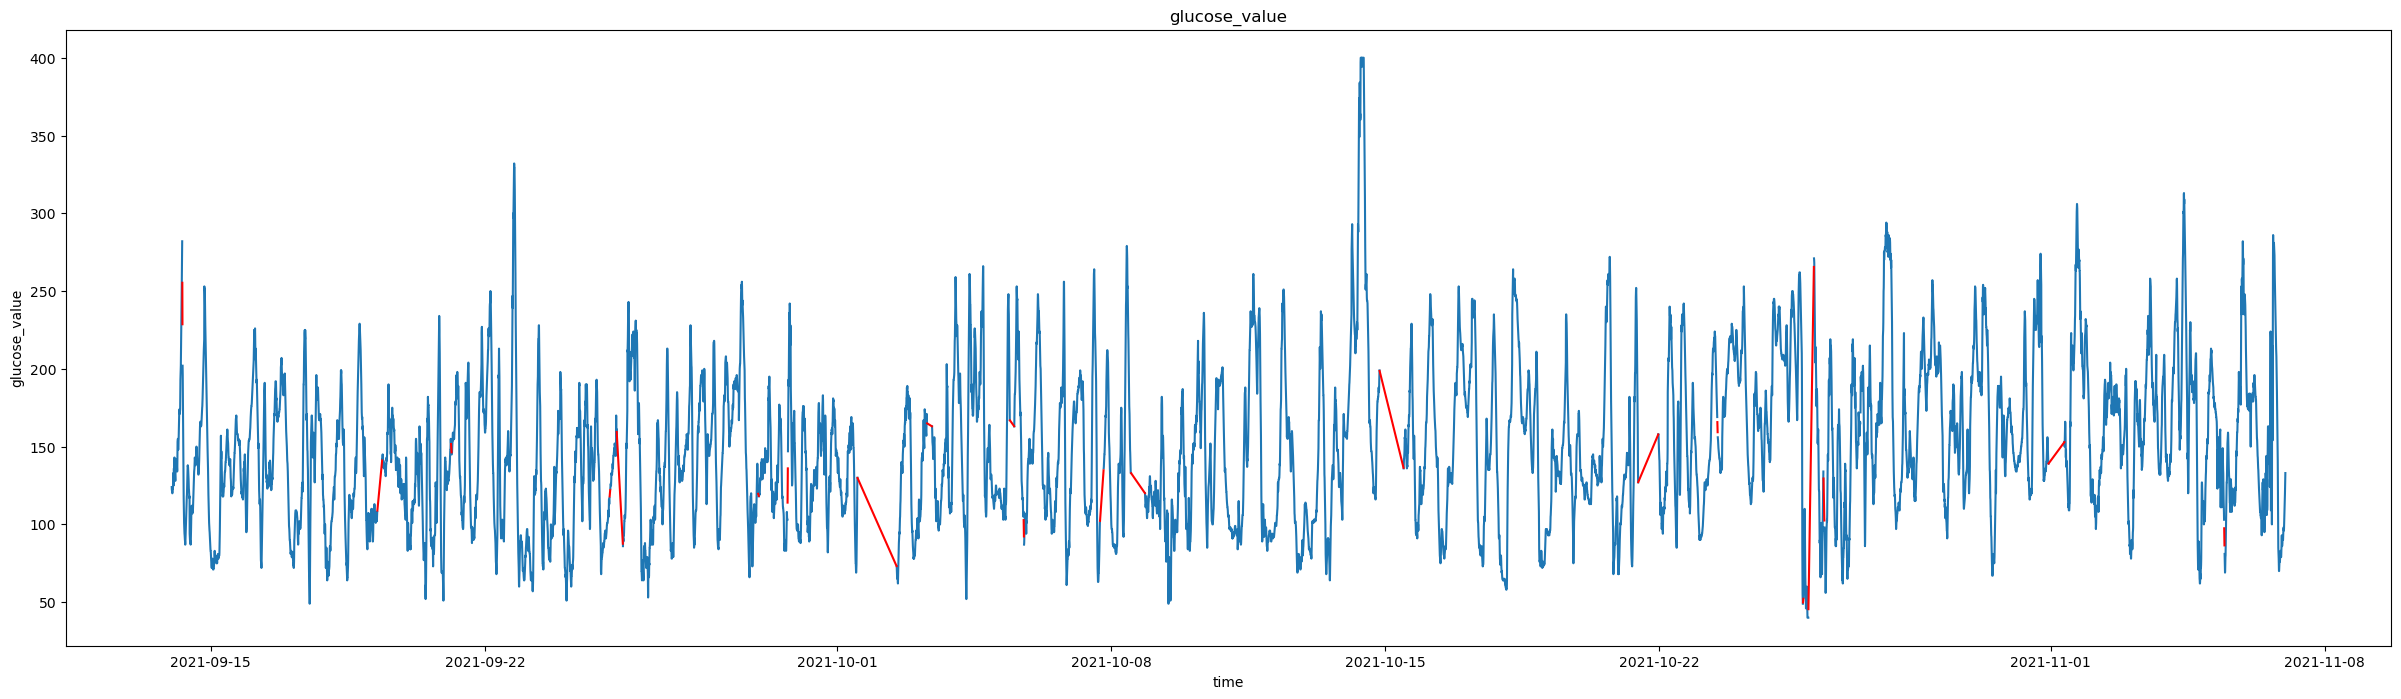

In [223]:
showMissing(df_563, df_nonmiss_563, 'glucose_value')

In [352]:
df_nonmiss_563.to_csv('processed data/GAN/563.csv', index=False)

In [225]:
df_glucose_miss_563 = getMissing(df_563, 'glucose_value')
df_glucose_miss_563[df_glucose_miss_563['duration'] > 12]

start                 end  duration
1  2021-09-19 06:05:00 2021-09-19 09:00:00        36
4  2021-09-25 08:50:00 2021-09-25 12:35:00        46
7  2021-10-01 12:30:00 2021-10-02 12:25:00       288
8  2021-10-03 07:10:00 2021-10-03 10:05:00        36
9  2021-10-05 09:55:00 2021-10-05 12:30:00        32
11 2021-10-07 17:10:00 2021-10-07 19:20:00        27
12 2021-10-08 12:15:00 2021-10-08 20:40:00       102
13 2021-10-14 20:35:00 2021-10-15 11:15:00       177
14 2021-10-21 11:10:00 2021-10-21 23:25:00       148
17 2021-10-25 19:30:00 2021-10-25 22:50:00        41
20 2021-10-31 22:45:00 2021-11-01 08:25:00       117

In [454]:
hyper_563, tir_563, l1_563, l2_563, mean_563, std_563 = getStatistics(df_nonmiss_563)

Hyper: 25.282921810699587
TIR: 72.77520576131687
L1 Hypo: 1.678240740740741
L2 Hypo: 0.2636316872427984
mean: 148.68470293209876
standard deviation: 48.957077524182424


# Patient 570

In [178]:
df_glucose_training_570 =  readData('data/training_1/570_training/data_glucose_level.csv')
df_glucose_test_570 =  readData('data/testing_1/570_testing/data_glucose_level.csv')
df_glucose_all_570 = pd.concat([df_glucose_training_570, df_glucose_test_570])
df_glucose_all_570 = df_glucose_all_570.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_570['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_570['ts'].iloc[-1]))

df_meal_training_570 =  readData('data/training_1/570_training/data_meal.csv')
df_meal_test_570 =  readData('data/testing_1/570_testing/data_meal.csv')
df_meal_all_570 = pd.concat([df_meal_training_570, df_meal_test_570])
df_meal_all_570 = df_meal_all_570.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_570['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_570['ts'].iloc[-1]))

The glucose data is recorded from 07-12-2021 16:29:00
The glucose data ends at 26-01-2022 23:57:00
The meal data is recorded from 07-12-2021 18:28:00
The meal data ends at 26-01-2022 18:30:00


In [179]:
len(df_meal_all_570)

169

In [26]:
date_new_570 = pd.date_range(start=datetime(2021, 12, 8, hour=0, minute=0), end=datetime(2022, 1, 27, hour=0, minute=0), freq='5min')
df_date_new_570 = pd.DataFrame(date_new_570, columns=['time'])

In [27]:
df_glucose_570, glucose_value_570 = dataSynchronize(df_glucose_all_570, df_date_new_570, '2021-12-7 23:55:00')

In [174]:
meal_value_570 = dataSynchronizeMeal(df_meal_all_570, df_date_new_570, '2021-12-7 23:55:00')

In [175]:
df_570 = pd.DataFrame(list(zip(date_new_570, glucose_value_570, meal_value_570)), columns=['time', 'glucose_value', 'meal_value'])

In [176]:
df_570

time glucose_value  meal_value
0     2021-12-08 00:00:00           127           0
1     2021-12-08 00:05:00           125           0
2     2021-12-08 00:10:00           124           0
3     2021-12-08 00:15:00           125           0
4     2021-12-08 00:20:00           125           0
...                   ...           ...         ...
14395 2022-01-26 23:35:00           202           0
14396 2022-01-26 23:40:00           204           0
14397 2022-01-26 23:45:00           208           0
14398 2022-01-26 23:50:00           212           0
14399 2022-01-26 23:55:00           218           0

[14400 rows x 3 columns]

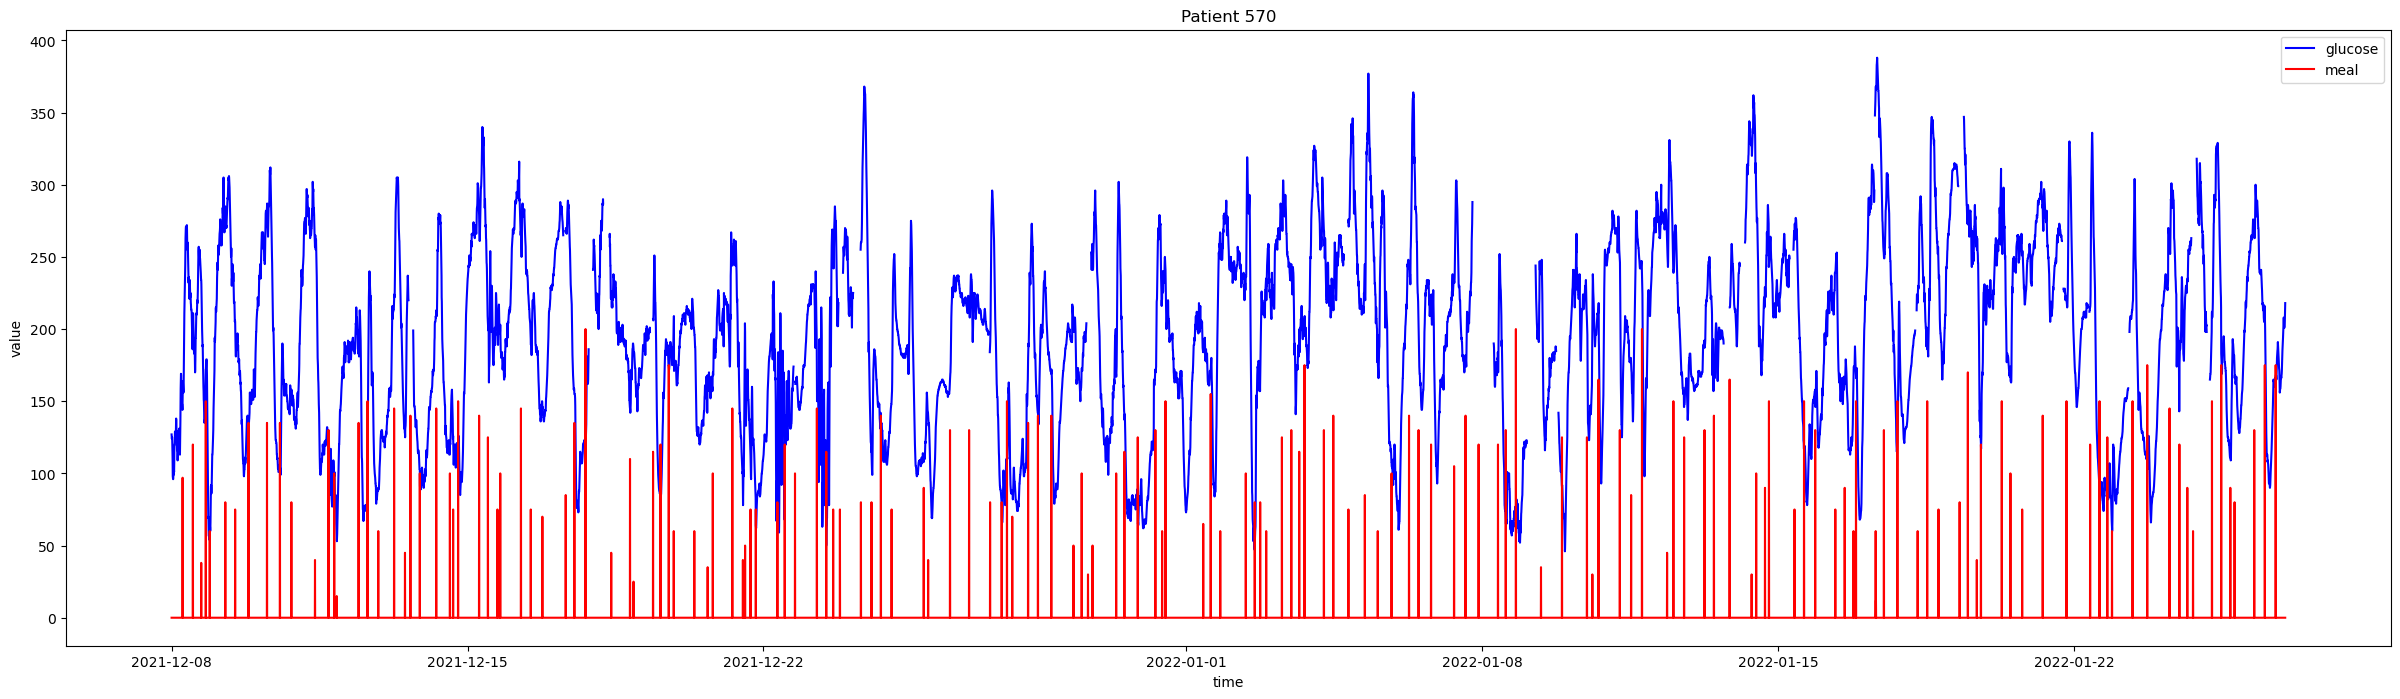

In [182]:
showFeatures(df_570, 'Patient 570')

In [177]:
df_570['date'] = df_570['time'].apply(lambda x: x.date())
dates = df_570['date'].unique()
daily_data = []
for date in dates:
    daily_data.append(df_570[df_570['date'] == date]['glucose_value'].values.tolist())

In [178]:
# the number of instances
len(daily_data)

50

linear interpolation

In [185]:
df_nonmiss_570 = pd.DataFrame(list(zip(df_570['time'], df_570['glucose_value'].astype(float).interpolate(),meal_value_570)), columns=['time', 'glucose_value', 'meal_value'])

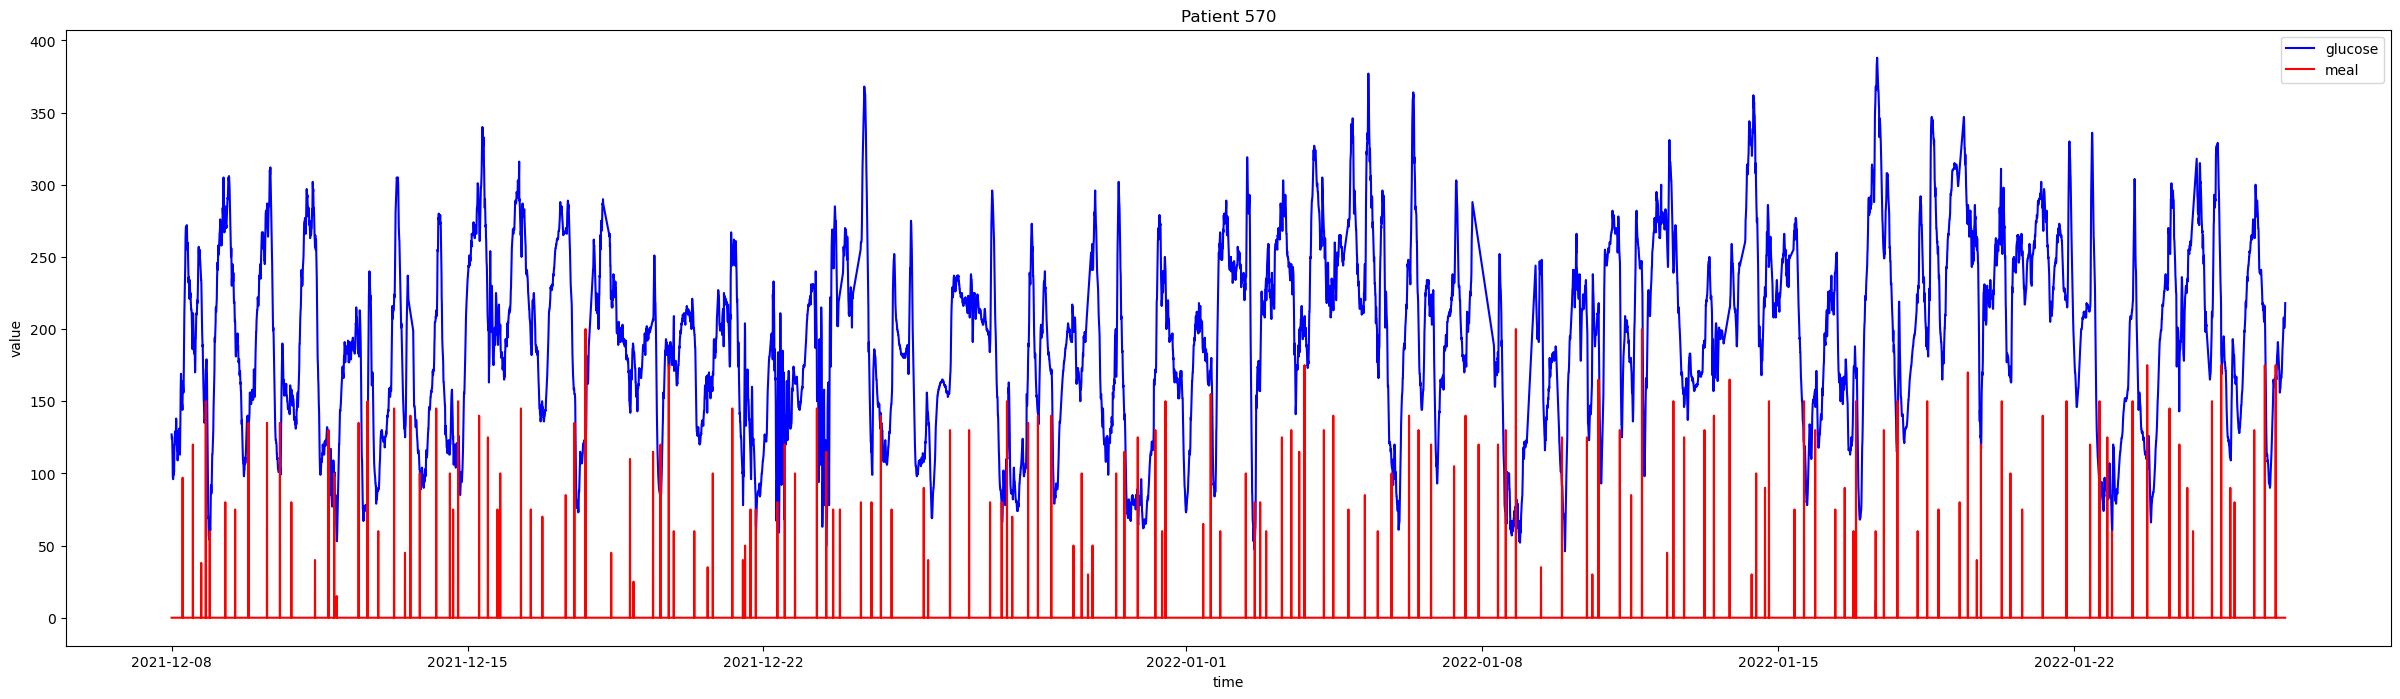

In [189]:
showFeatures(df_nonmiss_570, 'Patient 570')

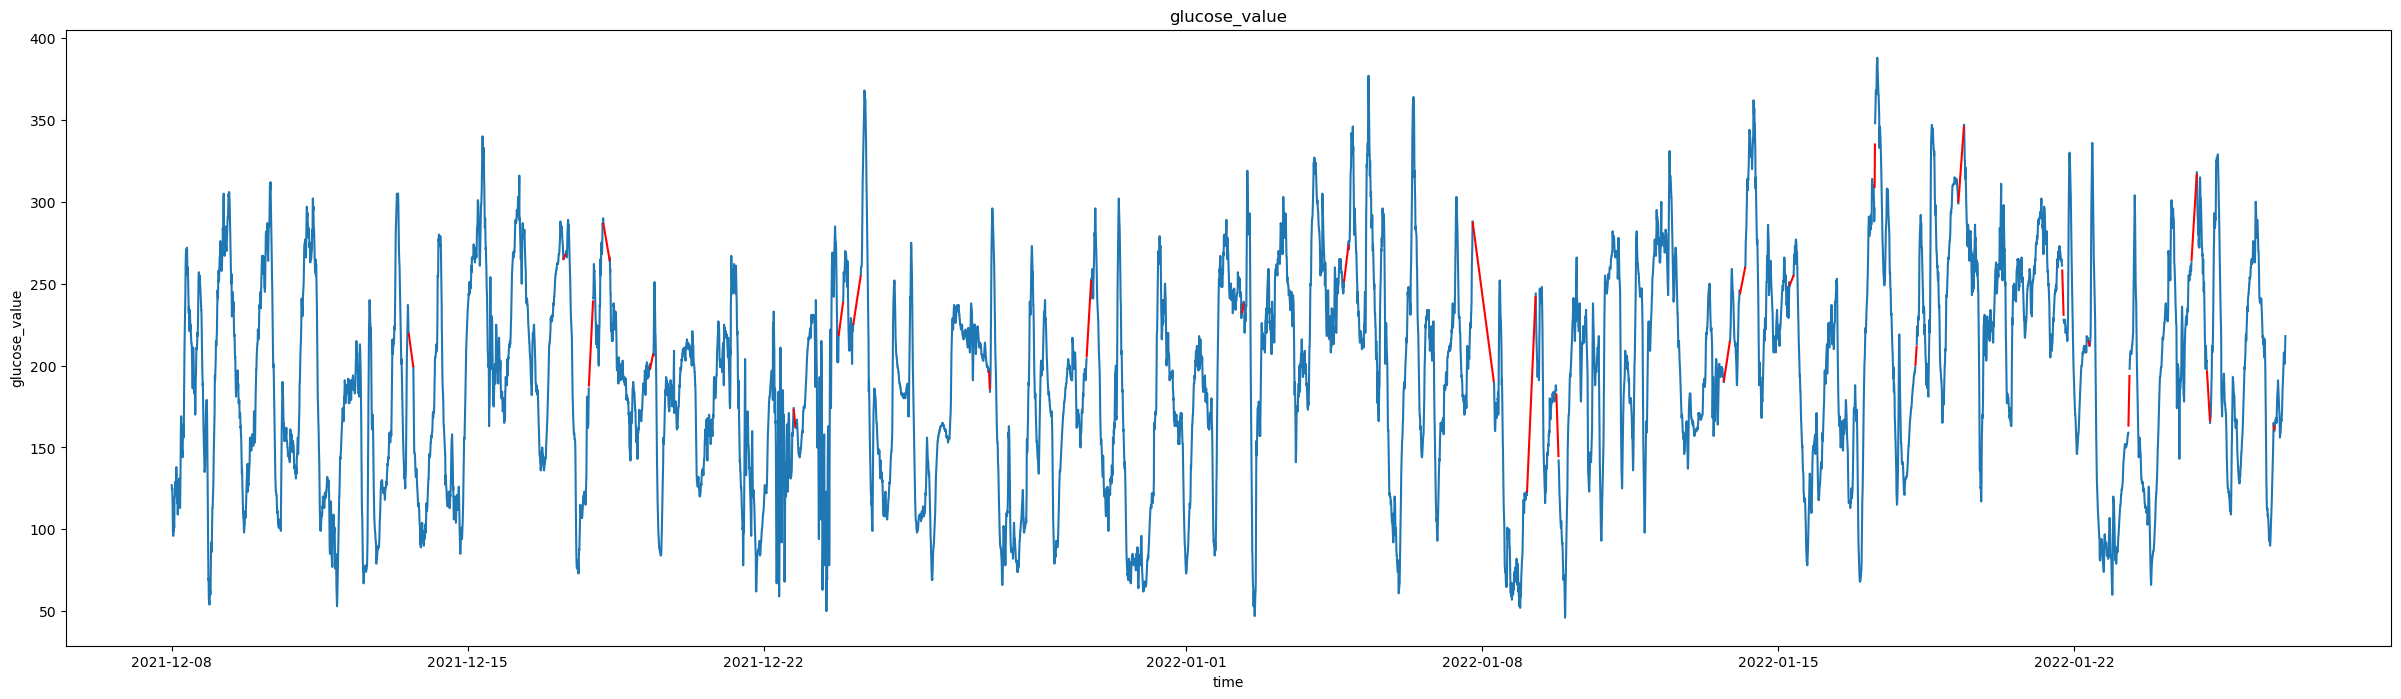

In [195]:
showMissing(df_570, df_nonmiss_570, 'glucose_value')

In [354]:
df_nonmiss_570.to_csv('processed data/GAN/570.csv', index=False)

In [350]:
df_glucose_miss_570 = getMissing(df_570, 'glucose_value')
df_glucose_miss_570[df_glucose_miss_570['duration'] > 12]

start                 end  duration
0  2021-12-13 14:35:00 2021-12-13 17:05:00        31
1  2021-12-17 06:25:00 2021-12-17 07:35:00        15
2  2021-12-17 20:50:00 2021-12-17 23:10:00        29
3  2021-12-18 05:05:00 2021-12-18 08:35:00        43
4  2021-12-19 07:40:00 2021-12-19 09:15:00        20
7  2021-12-23 18:40:00 2021-12-23 21:05:00        30
8  2021-12-24 03:00:00 2021-12-24 07:05:00        50
10 2021-12-29 15:25:00 2021-12-29 17:55:00        31
12 2022-01-04 17:35:00 2022-01-04 20:00:00        30
13 2022-01-07 18:35:00 2022-01-08 06:30:00       144
14 2022-01-09 01:25:00 2022-01-09 06:15:00        59
15 2022-01-09 18:05:00 2022-01-09 19:15:00        15
16 2022-01-13 17:10:00 2022-01-13 20:30:00        41
17 2022-01-14 02:25:00 2022-01-14 05:10:00        34
18 2022-01-15 06:35:00 2022-01-15 08:40:00        26
21 2022-01-19 06:20:00 2022-01-19 09:25:00        38
25 2022-01-24 18:40:00 2022-01-24 21:35:00        36
26 2022-01-25 03:25:00 2022-01-25 05:05:00        21

In [453]:
hyper_570, tir_570, l1_570, l2_570, mean_570, std_570 = getStatistics(df_nonmiss_570)

Hyper: 60.56944444444444
TIR: 38.00694444444444
L1 Hypo: 1.3263888888888888
L2 Hypo: 0.09722222222222222
mean: 195.5771875
standard deviation: 63.652888322307035


# Patient 575

In [180]:
df_glucose_training_575 =  readData('data/training_1/575_training/data_glucose_level.csv')
df_glucose_test_575 =  readData('data/testing_1/575_testing/data_glucose_level.csv')
df_glucose_all_575 = pd.concat([df_glucose_training_575, df_glucose_test_575])
df_glucose_all_575 = df_glucose_all_575.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_575['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_575['ts'].iloc[-1]))

df_meal_training_575 =  readData('data/training_1/575_training/data_meal.csv')
df_meal_test_575 =  readData('data/testing_1/575_testing/data_meal.csv')
df_meal_all_575 = pd.concat([df_meal_training_575, df_meal_test_575])
df_meal_all_575 = df_meal_all_575.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_575['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_575['ts'].iloc[-1]))

The glucose data is recorded from 17-11-2021 12:04:00
The glucose data ends at 11-01-2022 10:29:00
The meal data is recorded from 17-11-2021 14:18:00
The meal data ends at 11-01-2022 12:40:00


In [181]:
len(df_meal_all_575)

288

In [31]:
date_new_575 = pd.date_range(start=datetime(2021, 11, 18, hour=0, minute=0), end=datetime(2022, 1, 11, hour=0, minute=0), freq='5min')
df_date_new_575 = pd.DataFrame(date_new_575, columns=['time'])

In [32]:
df_glucose_575, glucose_value_575 = dataSynchronize(df_glucose_all_575, df_date_new_575, '2021-11-17 23:55:00')

In [229]:
meal_value_575 = dataSynchronizeMeal(df_meal_all_575, df_date_new_575, '2021-11-17 23:55:00')

In [230]:
df_575 = pd.DataFrame(list(zip(date_new_575, glucose_value_575, meal_value_575)), columns=['time', 'glucose_value', 'meal_value'])

In [231]:
df_575

time glucose_value  meal_value
0     2021-11-18 00:00:00           245           0
1     2021-11-18 00:05:00           251           0
2     2021-11-18 00:10:00           265           0
3     2021-11-18 00:15:00           276           0
4     2021-11-18 00:20:00           268           0
...                   ...           ...         ...
15547 2022-01-10 23:35:00           148           0
15548 2022-01-10 23:40:00           154           0
15549 2022-01-10 23:45:00           159           0
15550 2022-01-10 23:50:00           169           0
15551 2022-01-10 23:55:00           167           0

[15552 rows x 3 columns]

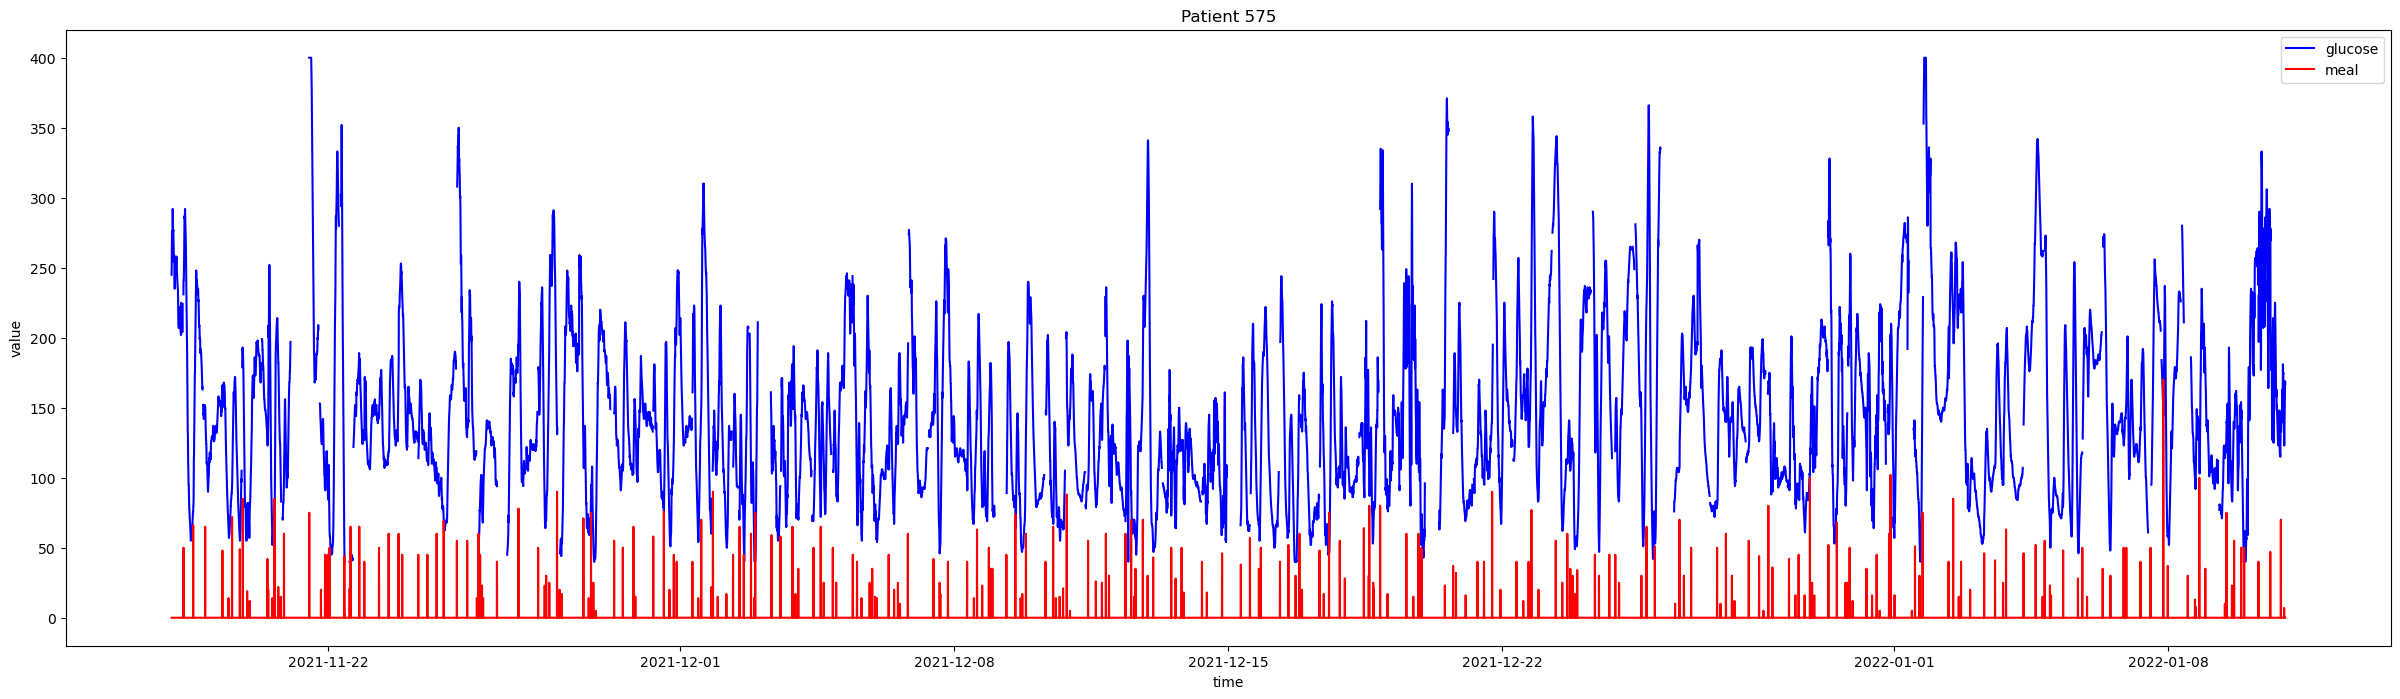

In [232]:
showFeatures(df_575, 'Patient 575')

In [233]:
df_575['date'] = df_575['time'].apply(lambda x: x.date())
dates = df_575['date'].unique()
daily_data = []
for date in dates:
    daily_data.append(df_575[df_575['date'] == date]['glucose_value'].values.tolist())

In [234]:
len(daily_data)

54

In [235]:
df_nonmiss_575 = pd.DataFrame(list(zip(df_575['time'], df_575['glucose_value'].astype(float).interpolate(),meal_value_575)), columns=['time', 'glucose_value', 'meal_value'])

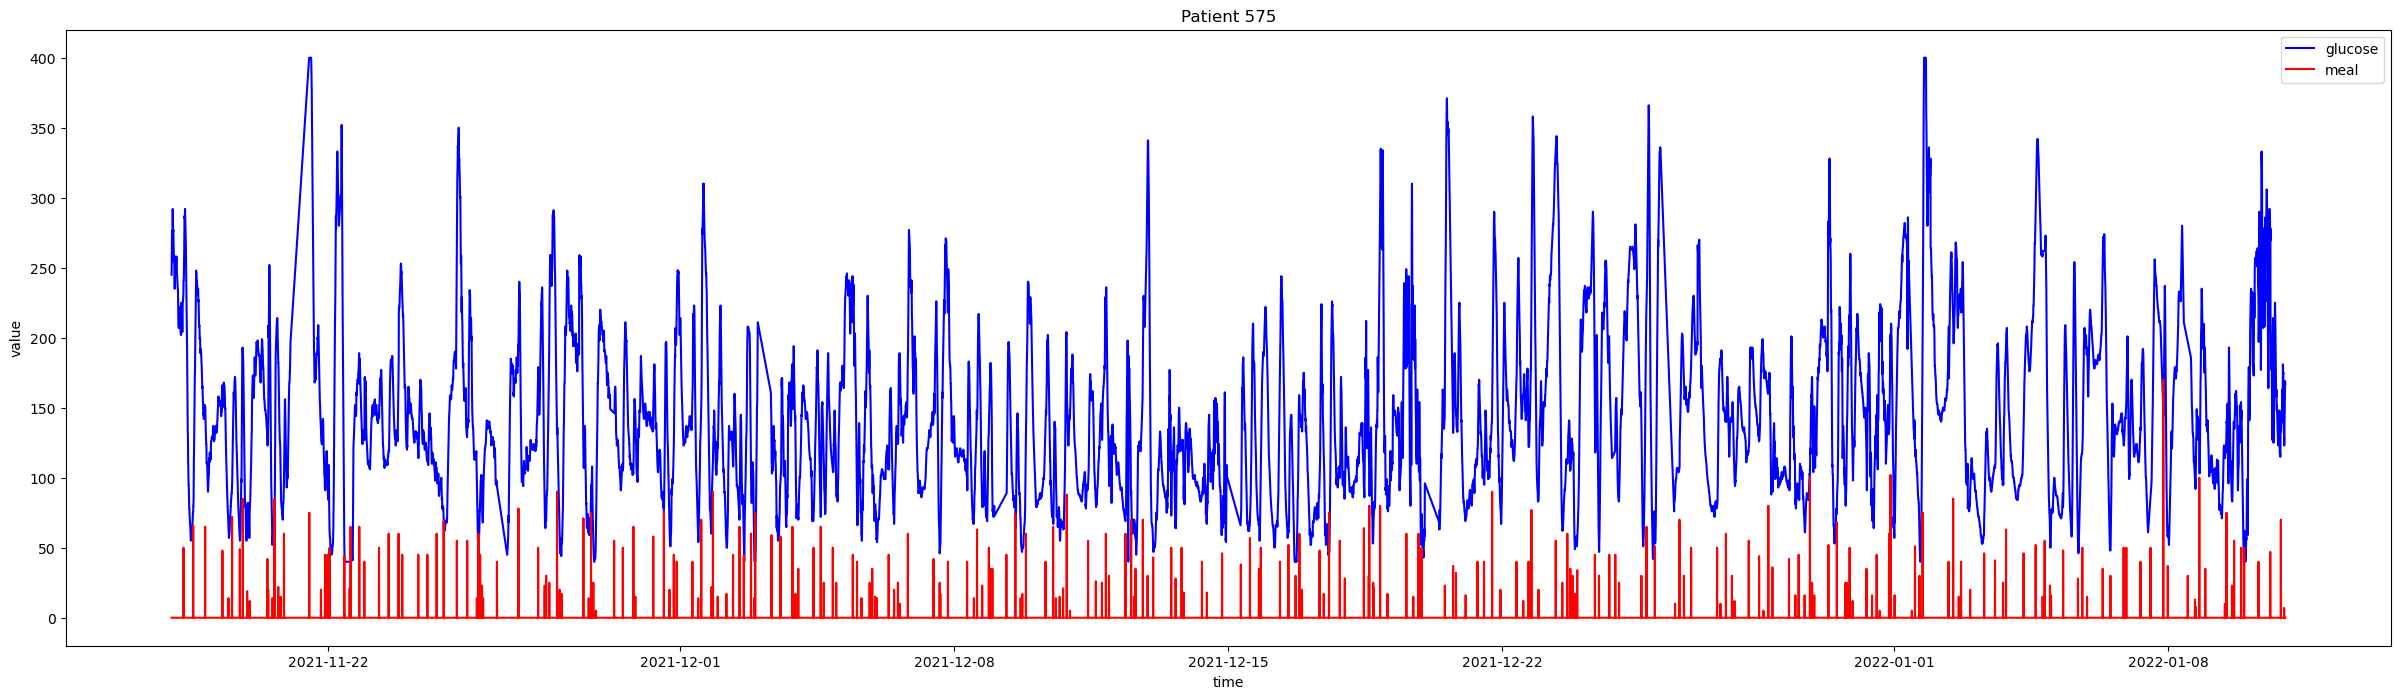

In [236]:
showFeatures(df_nonmiss_575, 'Patient 575')

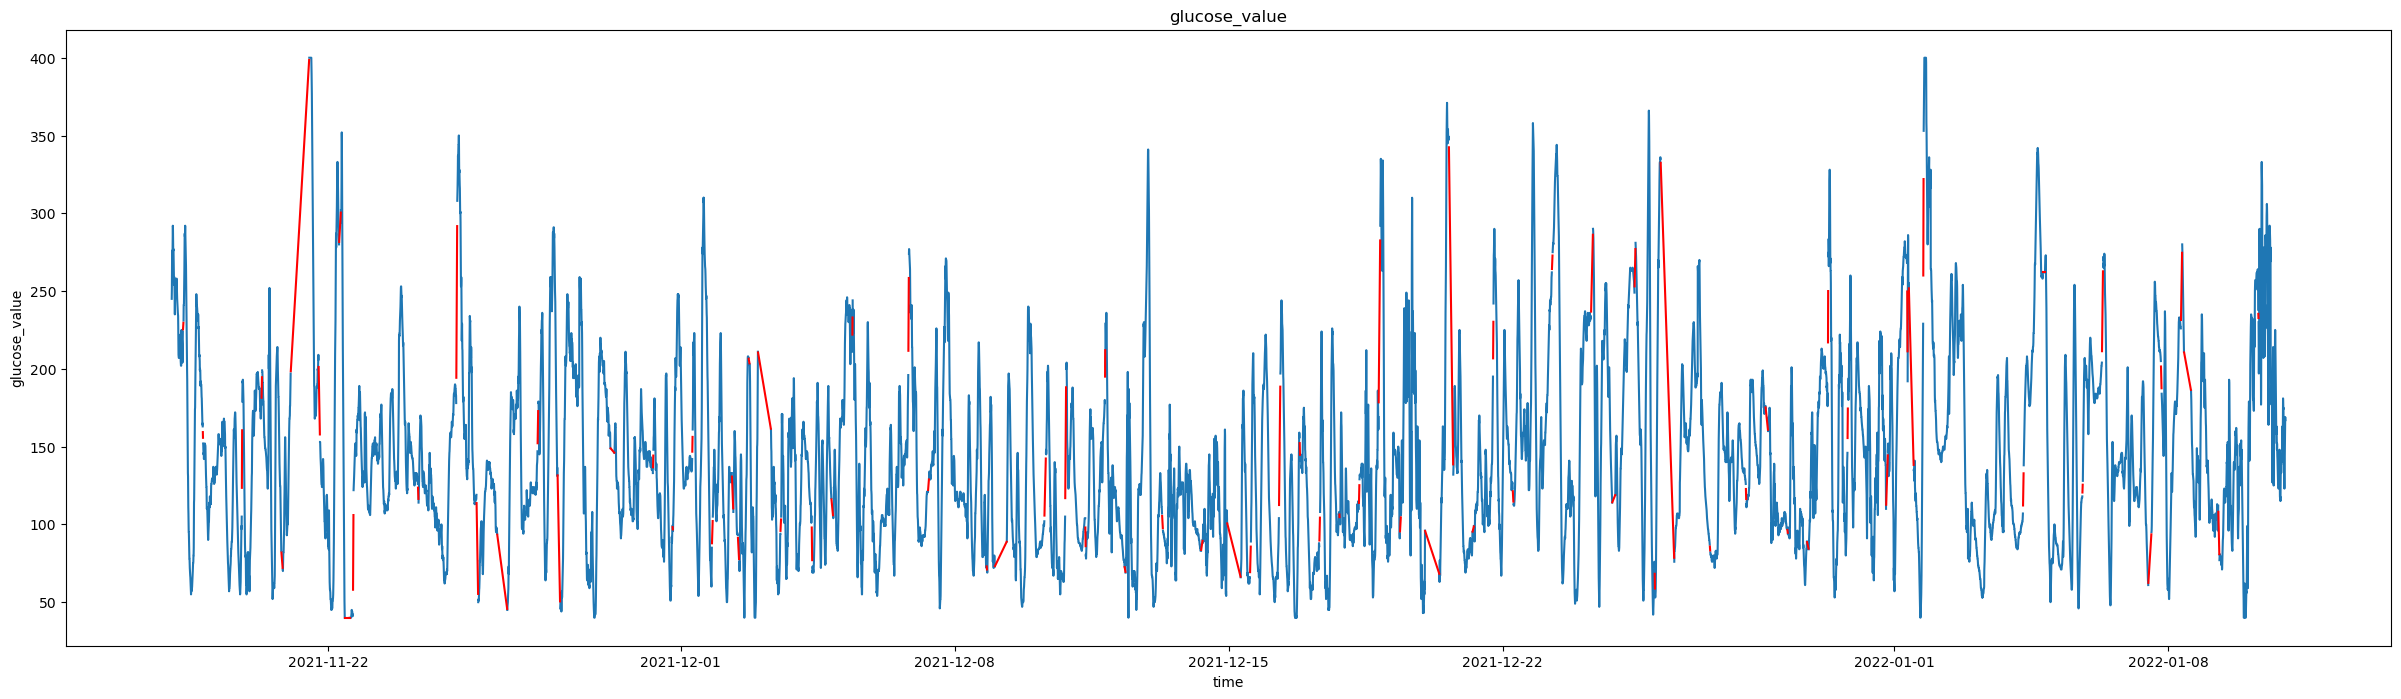

In [237]:
showMissing(df_575, df_nonmiss_575, 'glucose_value')

In [355]:
df_nonmiss_575.to_csv('processed data/GAN/575.csv', index=False)

In [356]:
df_glucose_miss_575 = getMissing(df_575, 'glucose_value')
df_glucose_miss_575[df_glucose_miss_575['duration'] > 12]

start                 end  duration
5  2021-11-21 01:00:00 2021-11-21 12:15:00       136
7  2021-11-22 06:40:00 2021-11-22 07:40:00        13
8  2021-11-22 10:10:00 2021-11-22 13:00:00        35
13 2021-11-26 07:35:00 2021-11-26 13:40:00        74
15 2021-11-27 20:35:00 2021-11-27 22:05:00        19
16 2021-11-29 05:05:00 2021-11-29 07:20:00        28
24 2021-12-02 23:30:00 2021-12-03 07:20:00        95
32 2021-12-09 00:45:00 2021-12-09 07:55:00        87
40 2021-12-14 23:10:00 2021-12-15 07:20:00        99
49 2021-12-20 00:30:00 2021-12-20 09:10:00       105
50 2021-12-20 15:05:00 2021-12-20 17:40:00        32
55 2021-12-24 06:15:00 2021-12-24 07:20:00        14
56 2021-12-24 19:15:00 2021-12-24 21:00:00        22
59 2021-12-26 00:55:00 2021-12-26 09:10:00       100
62 2021-12-28 17:15:00 2021-12-28 18:40:00        18
67 2021-12-31 19:10:00 2021-12-31 20:10:00        13
69 2022-01-01 09:05:00 2022-01-01 12:00:00        36
72 2022-01-04 19:20:00 2022-01-04 20:30:00        15
75 2022-01-07 11:55:00 2022-01-07 13:45:00        23
78 2022-01-08 09:50:00 2022-01-08 14:00:00        51

In [452]:
hyper_575, tir_575, l1_575, l2_575, mean_575, std_575 = getStatistics(df_nonmiss_575)

Hyper: 25.848765432098762
TIR: 66.5380658436214
L1 Hypo: 5.4205246913580245
L2 Hypo: 2.1926440329218106
mean: 144.76154192386832
standard deviation: 63.04644235434572


# Patient 588

In [182]:
df_glucose_training_588 =  readData('data/training_1/588_training/data_glucose_level.csv')
df_glucose_test_588 =  readData('data/testing_1/588_testing/data_glucose_level.csv')
df_glucose_all_588 = pd.concat([df_glucose_training_588, df_glucose_test_588])
df_glucose_all_588 = df_glucose_all_588.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_588['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_588['ts'].iloc[-1]))

df_meal_training_588 =  readData('data/training_1/588_training/data_meal.csv')
df_meal_test_588 =  readData('data/testing_1/588_testing/data_meal.csv')
df_meal_all_588 = pd.concat([df_meal_training_588, df_meal_test_588])
df_meal_all_588 = df_meal_all_588.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_588['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_588['ts'].iloc[-1]))

The glucose data is recorded from 30-08-2021 11:53:00
The glucose data ends at 24-10-2021 23:58:00
The meal data is recorded from 30-08-2021 11:59:00
The meal data ends at 24-10-2021 19:58:00


In [183]:
len(df_meal_all_588)

258

In [36]:
date_new_588 = pd.date_range(start=datetime(2021, 8, 31, hour=0, minute=0), end=datetime(2021, 10, 25, hour=0, minute=0), freq='5min')
df_date_new_588 = pd.DataFrame(date_new_588, columns=['time'])

In [37]:
df_glucose_588, glucose_value_588 = dataSynchronize(df_glucose_all_588, df_date_new_588, '2021-8-30 23:55:00')

In [324]:
meal_value_588 = dataSynchronizeMeal(df_meal_all_588, df_date_new_588, '2021-8-30 23:55:00')

In [325]:
df_588 = pd.DataFrame(list(zip(date_new_588, glucose_value_588, meal_value_588)), columns=['time', 'glucose_value', 'meal_value'])

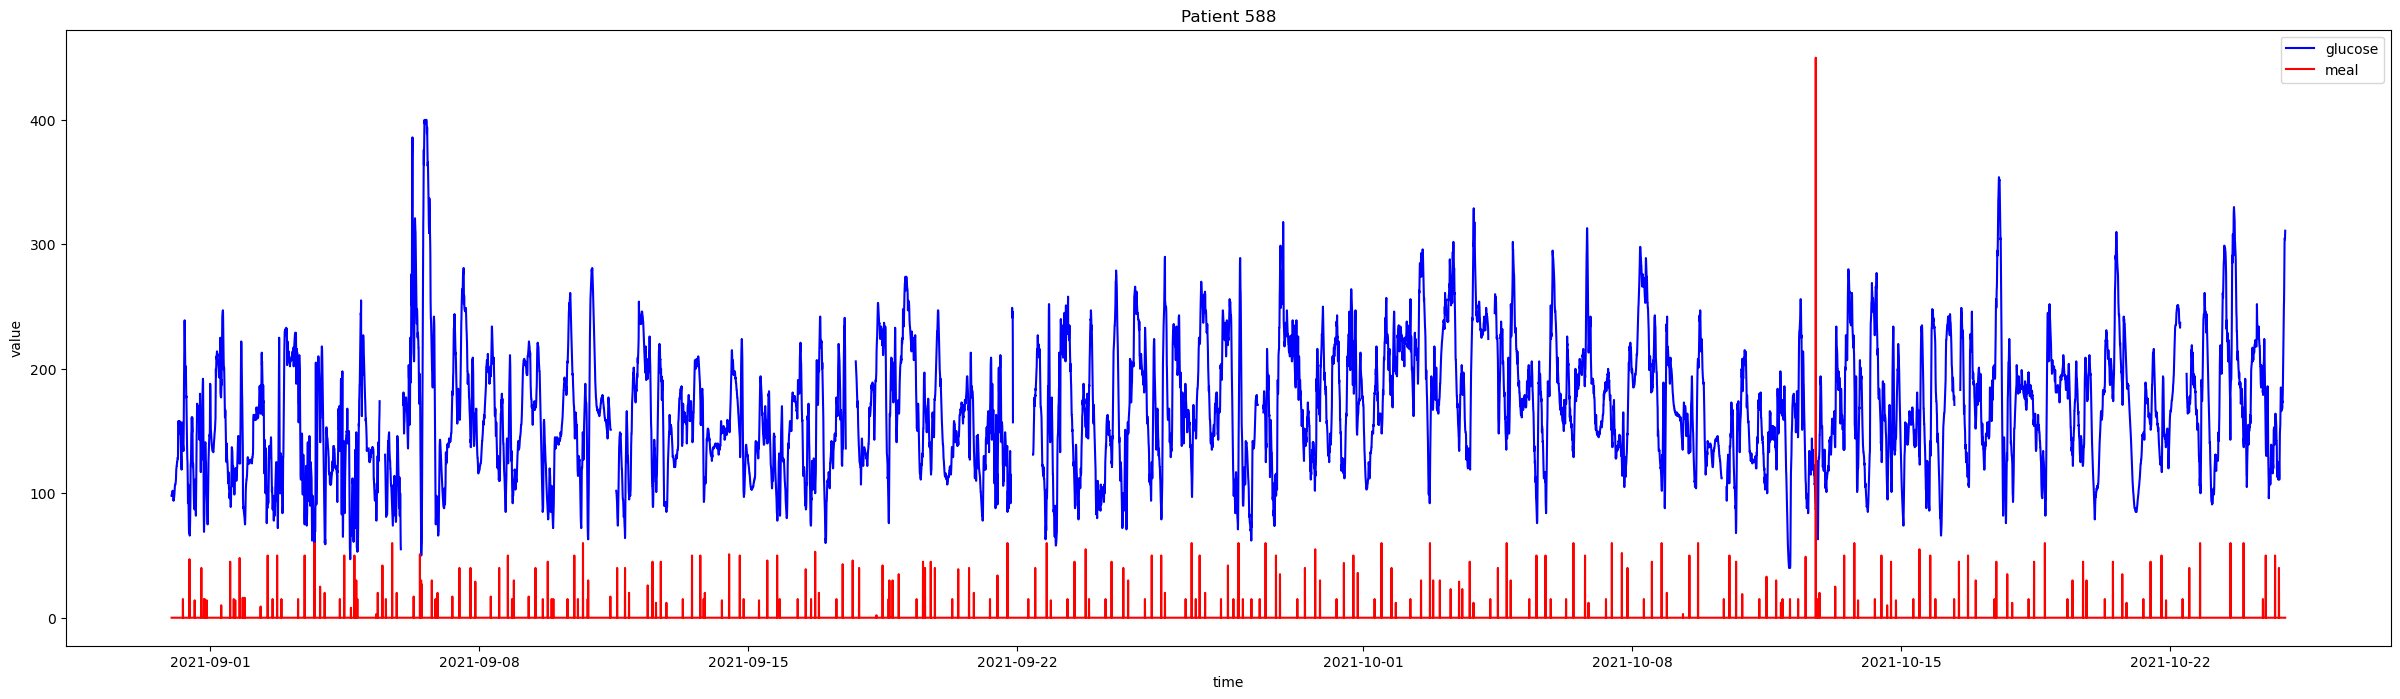

In [326]:
showFeatures(df_588, 'Patient 588')

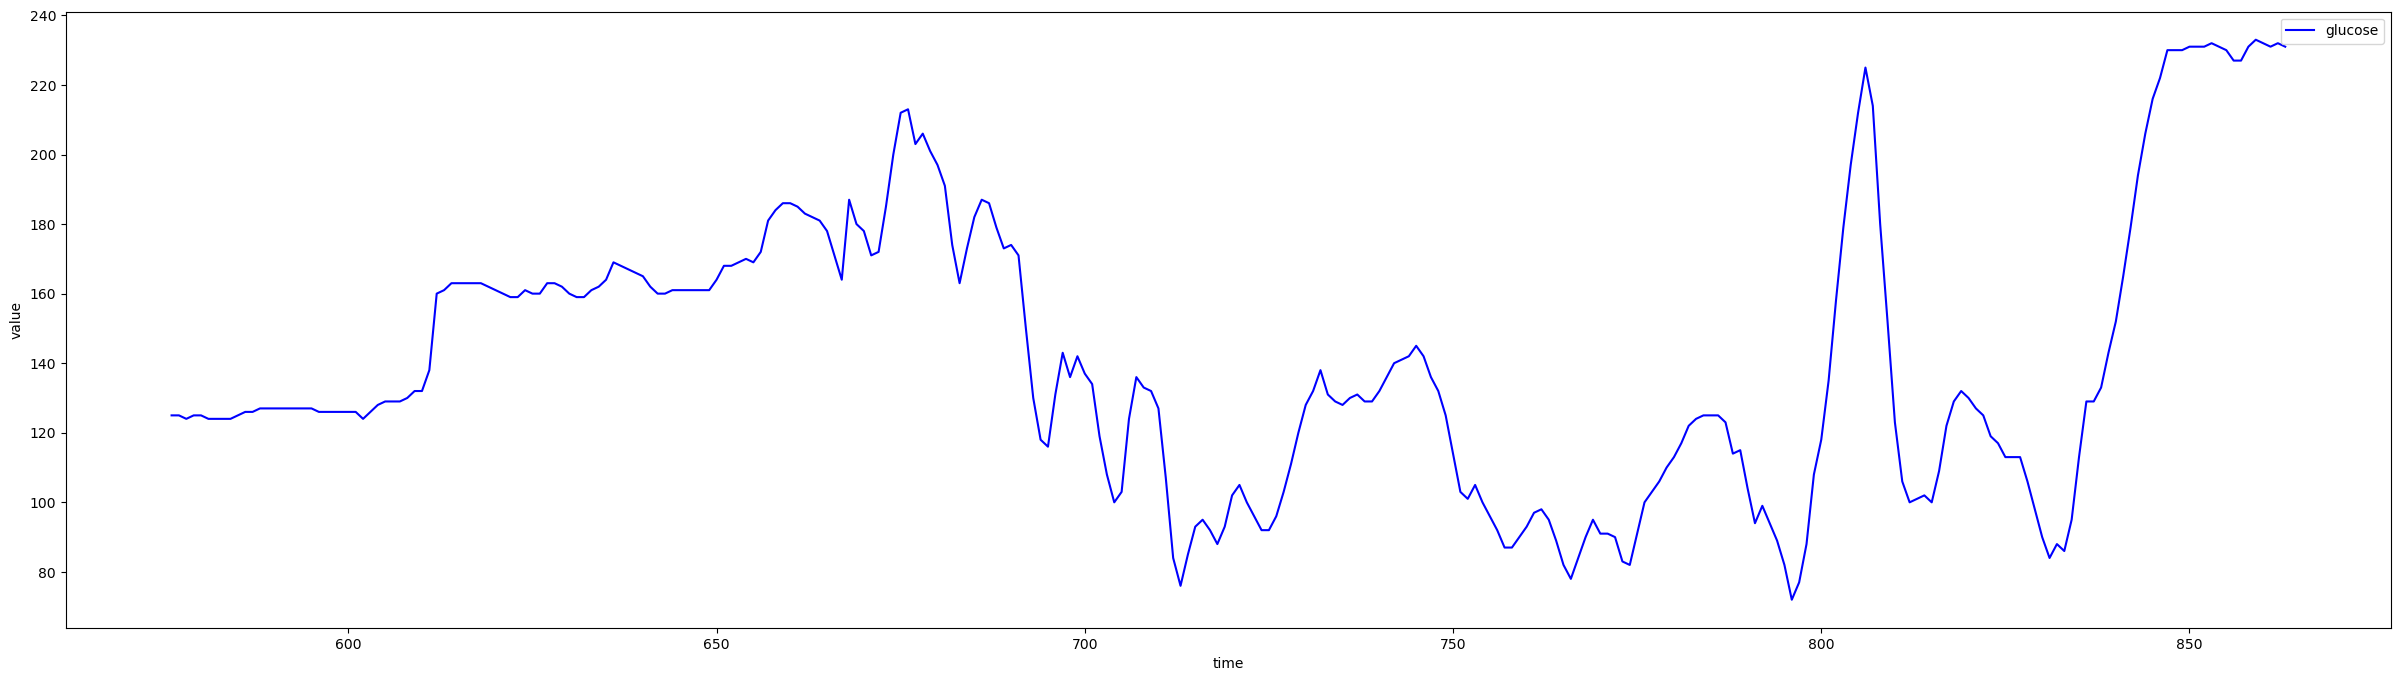

In [462]:
plt.figure(figsize=(30,8))
plt.plot(df_588['glucose_value'][576:864], 'b', label='glucose')
plt.xlabel("time")
plt.ylabel("value")
plt.legend()

plt.show()

In [327]:
df_588['date'] = df_588['time'].apply(lambda x: x.date())
dates = df_588['date'].unique()
daily_data = []
for date in dates:
    daily_data.append(df_588[df_588['date'] == date]['glucose_value'].values.tolist())

In [328]:
len(daily_data)

55

In [329]:
df_nonmiss_588 = pd.DataFrame(list(zip(df_588['time'], df_588['glucose_value'].astype(float).interpolate(),meal_value_588)), columns=['time', 'glucose_value', 'meal_value'])

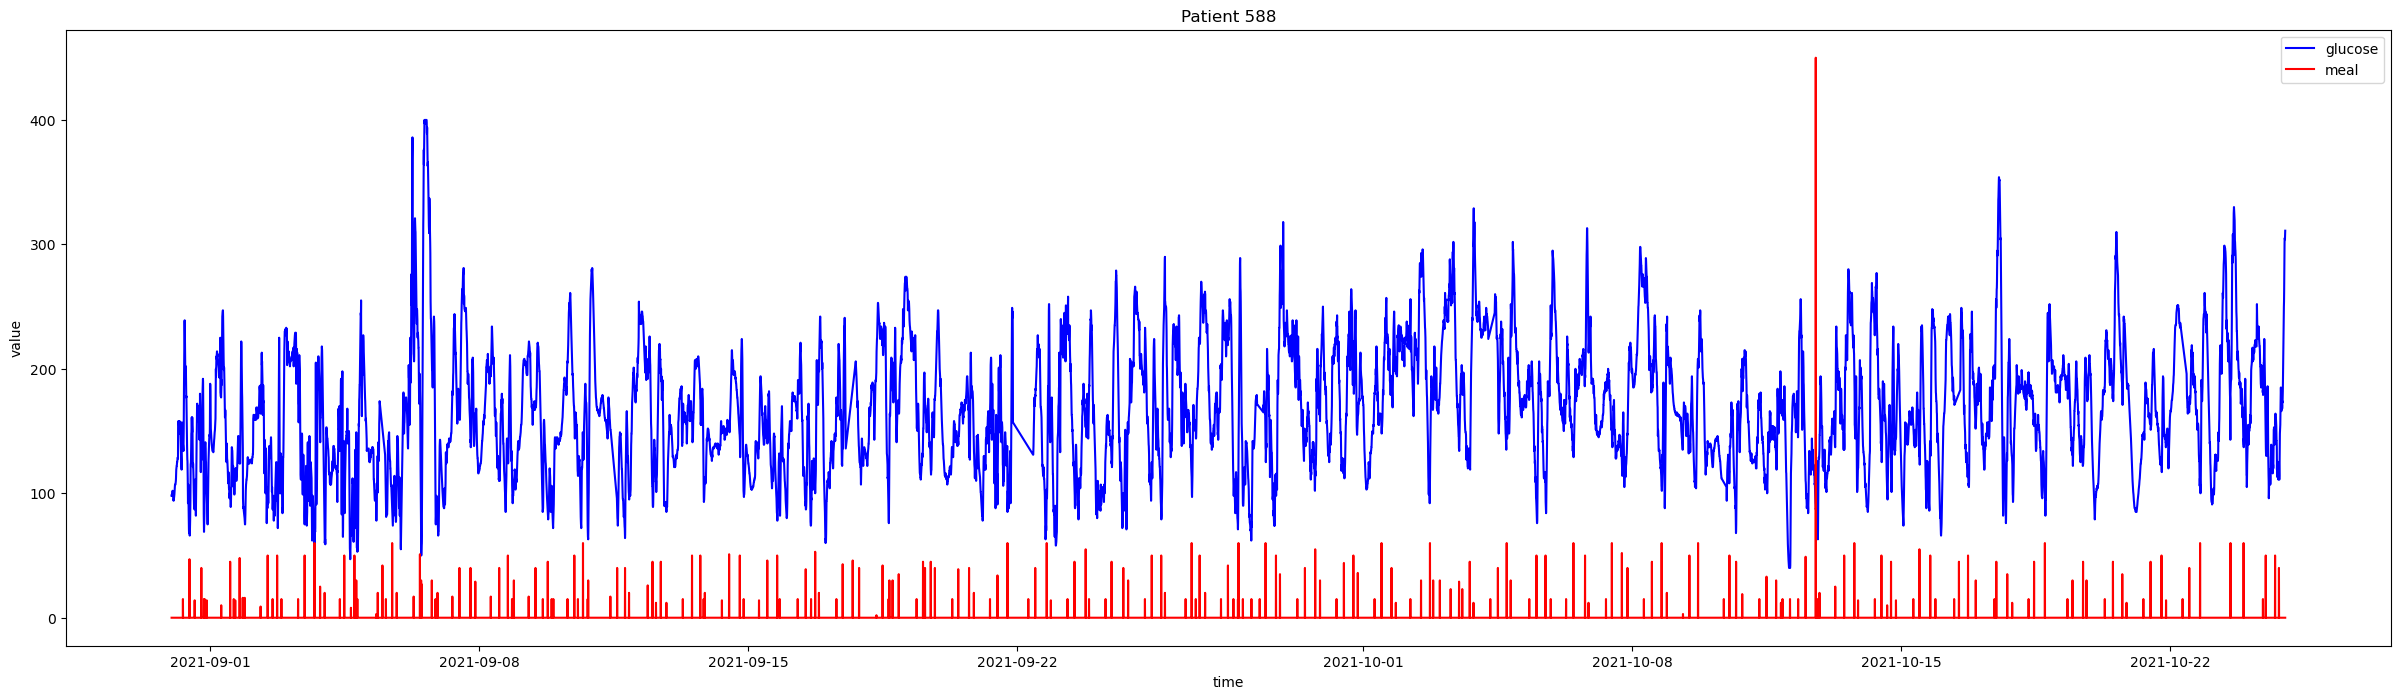

In [330]:
showFeatures(df_nonmiss_588, 'Patient 588')

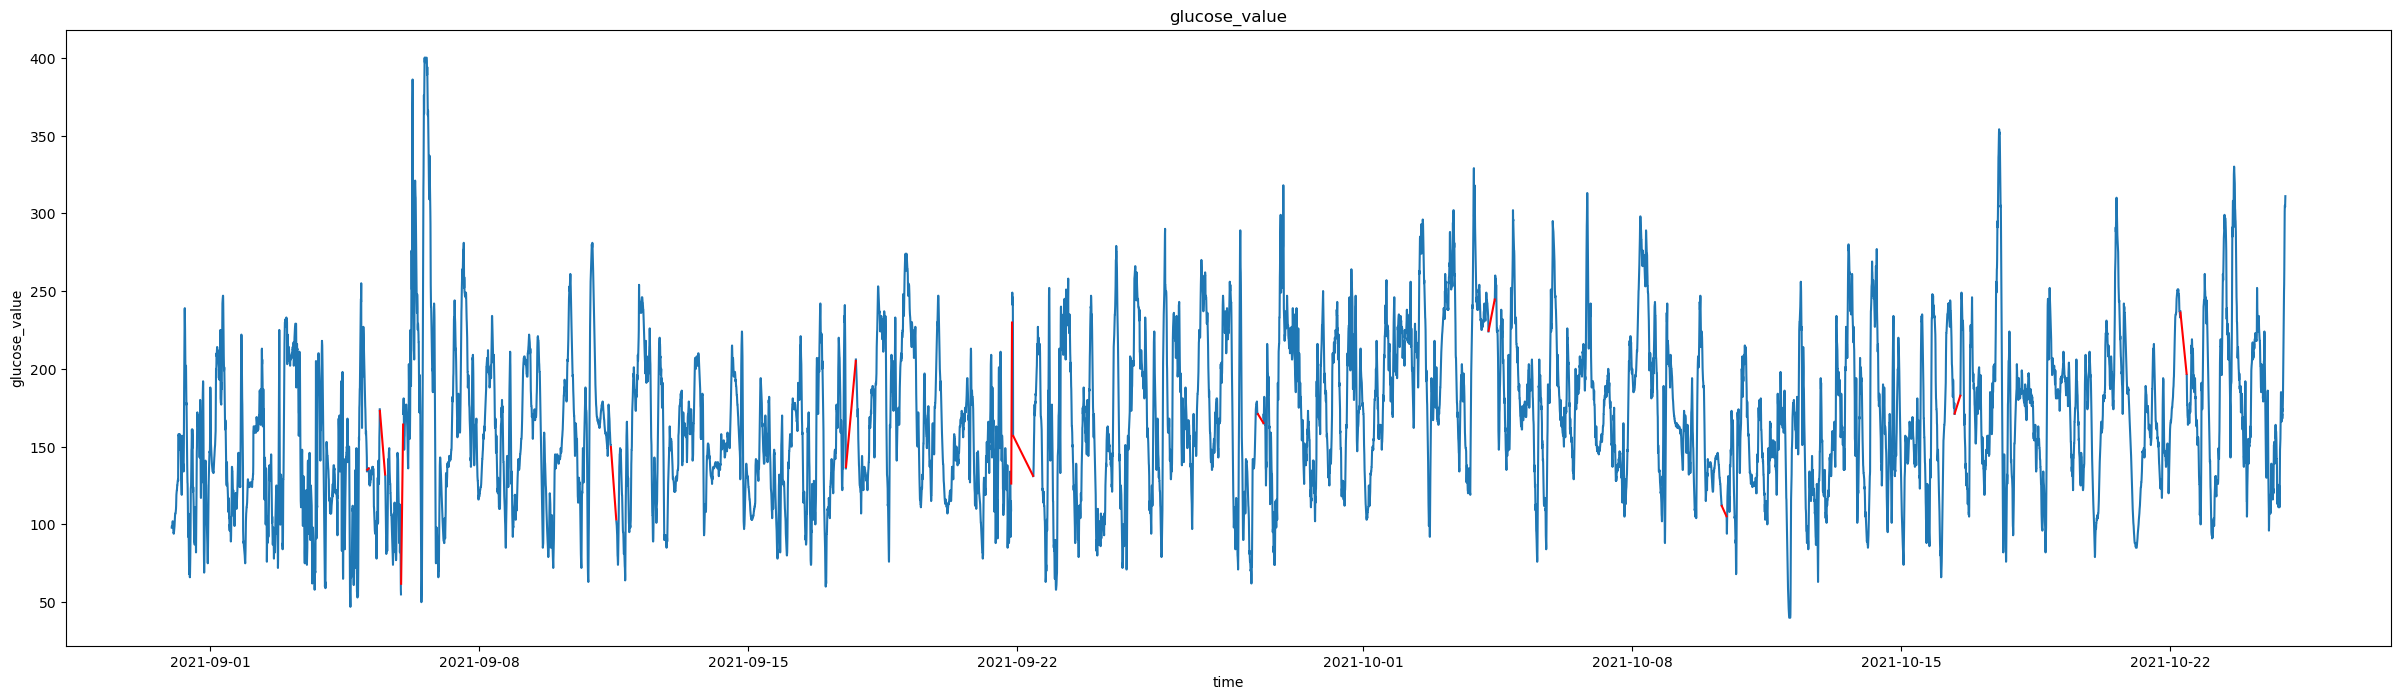

In [331]:
showMissing(df_588, df_nonmiss_588, 'glucose_value')

In [357]:
df_nonmiss_588.to_csv('processed data/GAN/588.csv', index=False)

In [333]:
df_glucose_miss_588 = getMissing(df_588, 'glucose_value')
df_glucose_miss_588[df_glucose_miss_588['duration'] > 12]

start                 end  duration
1  2021-09-05 10:00:00 2021-09-05 13:15:00        40
2  2021-09-05 23:15:00 2021-09-06 00:30:00        16
3  2021-09-11 10:15:00 2021-09-11 13:35:00        41
4  2021-09-17 13:05:00 2021-09-17 19:10:00        74
6  2021-09-21 21:30:00 2021-09-22 09:55:00       150
7  2021-09-28 06:20:00 2021-09-28 09:45:00        42
8  2021-10-04 06:20:00 2021-10-04 10:10:00        47
9  2021-10-10 08:00:00 2021-10-10 10:55:00        36
10 2021-10-16 09:25:00 2021-10-16 12:55:00        43
11 2021-10-22 06:25:00 2021-10-22 10:15:00        47

In [426]:
hyper_588, tir_588, l1_588, l2_588, mean_588, std_588 = getStatistics(df_nonmiss_588)

Hyper: 37.80934343434343
TIR: 61.40151515151515
L1 Hypo: 0.6313131313131313
L2 Hypo: 0.15782828282828282
mean: 167.20482954545454
standard deviation: 49.750245799791024


# Patient 591

In [184]:
df_glucose_training_591 =  readData('data/training_1/591_training/data_glucose_level.csv')
df_glucose_test_591 =  readData('data/testing_1/591_testing/data_glucose_level.csv')
df_glucose_all_591 = pd.concat([df_glucose_training_591, df_glucose_test_591])
df_glucose_all_591 = df_glucose_all_591.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_591['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_591['ts'].iloc[-1]))

df_meal_training_591 =  readData('data/training_1/591_training/data_meal.csv')
df_meal_test_591 =  readData('data/testing_1/591_testing/data_meal.csv')
df_meal_all_591 = pd.concat([df_meal_training_591, df_meal_test_591])
df_meal_all_591 = df_meal_all_591.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_591['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_591['ts'].iloc[-1]))

The glucose data is recorded from 30-11-2021 17:06:00
The glucose data ends at 23-01-2022 21:13:00
The meal data is recorded from 30-11-2021 16:45:00
The meal data ends at 23-01-2022 21:09:00


In [185]:
len(df_meal_all_591)

253

In [41]:
date_new_591 = pd.date_range(start=datetime(2021, 12, 1, hour=0, minute=0), end=datetime(2022, 1, 23, hour=0, minute=0), freq='5min')
df_date_new_591 = pd.DataFrame(date_new_591, columns=['time'])

In [42]:
df_glucose_591, glucose_value_591 = dataSynchronize(df_glucose_all_591, df_date_new_591, '2021-11-30 23:55:00')

In [340]:
meal_value_591 = dataSynchronizeMeal(df_meal_all_591, df_date_new_591, '2021-11-30 23:55:00')

In [341]:
df_591 = pd.DataFrame(list(zip(date_new_591, glucose_value_591, meal_value_591)), columns=['time', 'glucose_value', 'meal_value'])

In [342]:
df_591

time glucose_value  meal_value
0     2021-12-01 00:00:00           129           0
1     2021-12-01 00:05:00           121           0
2     2021-12-01 00:10:00           109           0
3     2021-12-01 00:15:00            98           0
4     2021-12-01 00:20:00            87           0
...                   ...           ...         ...
15259 2022-01-22 23:35:00           150           0
15260 2022-01-22 23:40:00           149           0
15261 2022-01-22 23:45:00           148           0
15262 2022-01-22 23:50:00           147           0
15263 2022-01-22 23:55:00           145           0

[15264 rows x 3 columns]

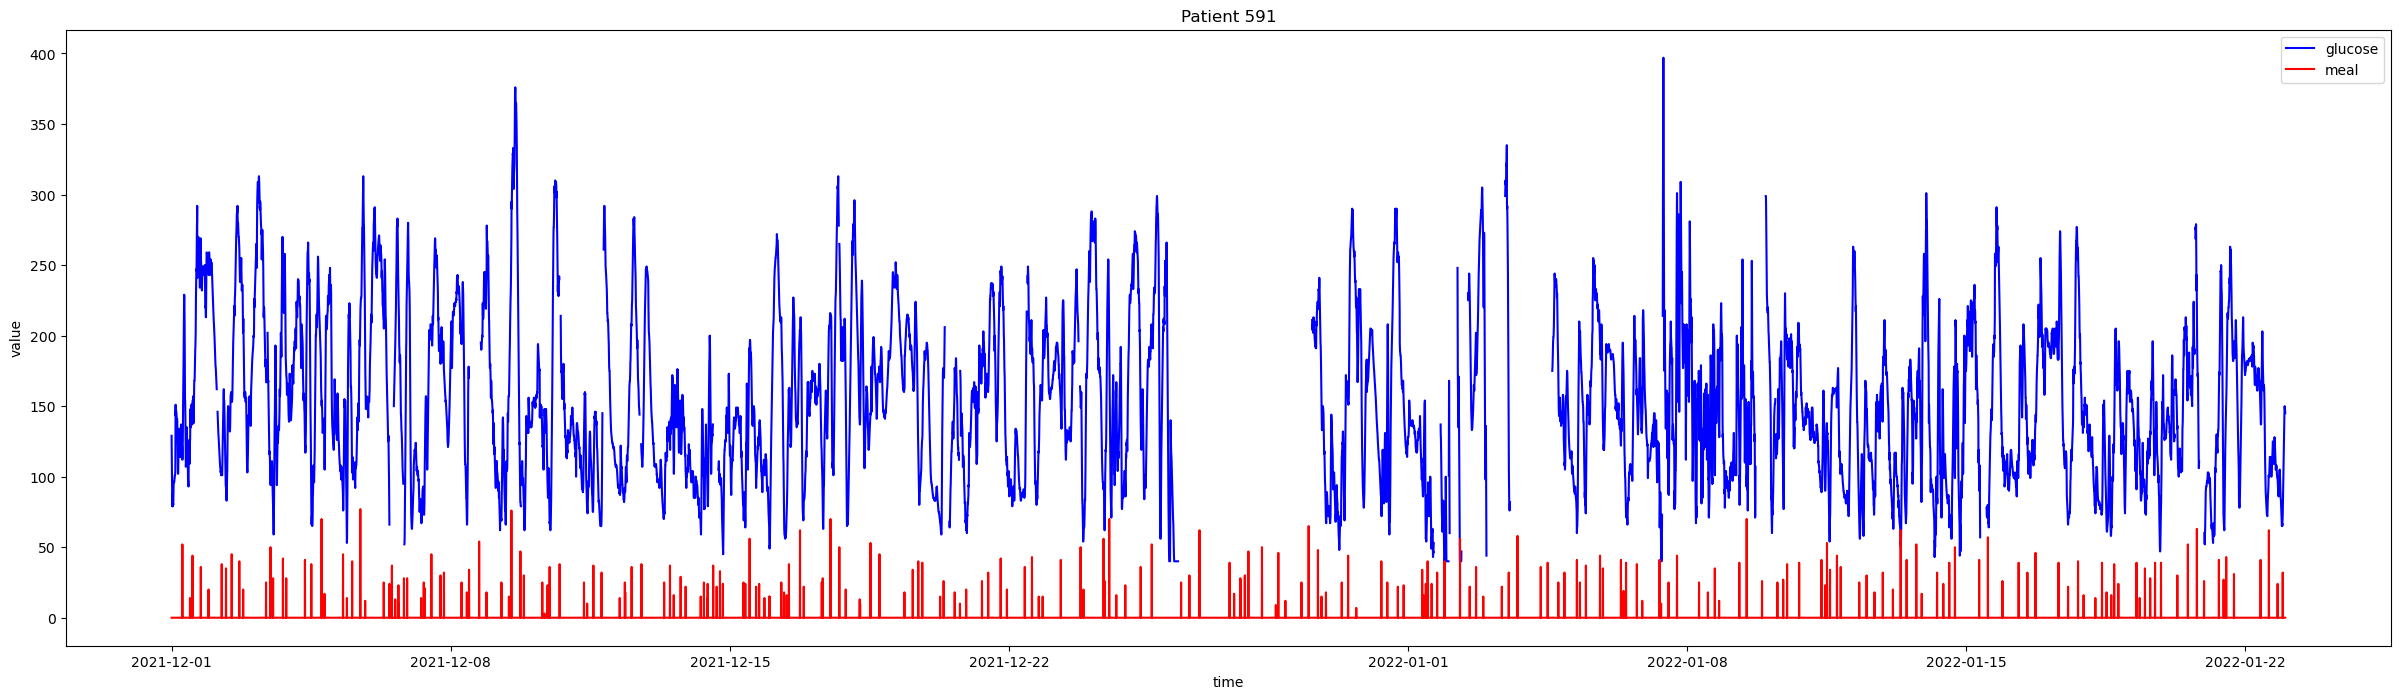

In [343]:
showFeatures(df_591, 'Patient 591')

In [344]:
df_591['date'] = df_591['time'].apply(lambda x: x.date())
dates = df_591['date'].unique()
daily_data = []
for date in dates:
    daily_data.append(df_591[df_591['date'] == date]['glucose_value'].values.tolist())

In [345]:
len(daily_data)

53

In [346]:
df_nonmiss_591 = pd.DataFrame(list(zip(df_591['time'], df_591['glucose_value'].astype(float).interpolate(),meal_value_591)), columns=['time', 'glucose_value', 'meal_value'])

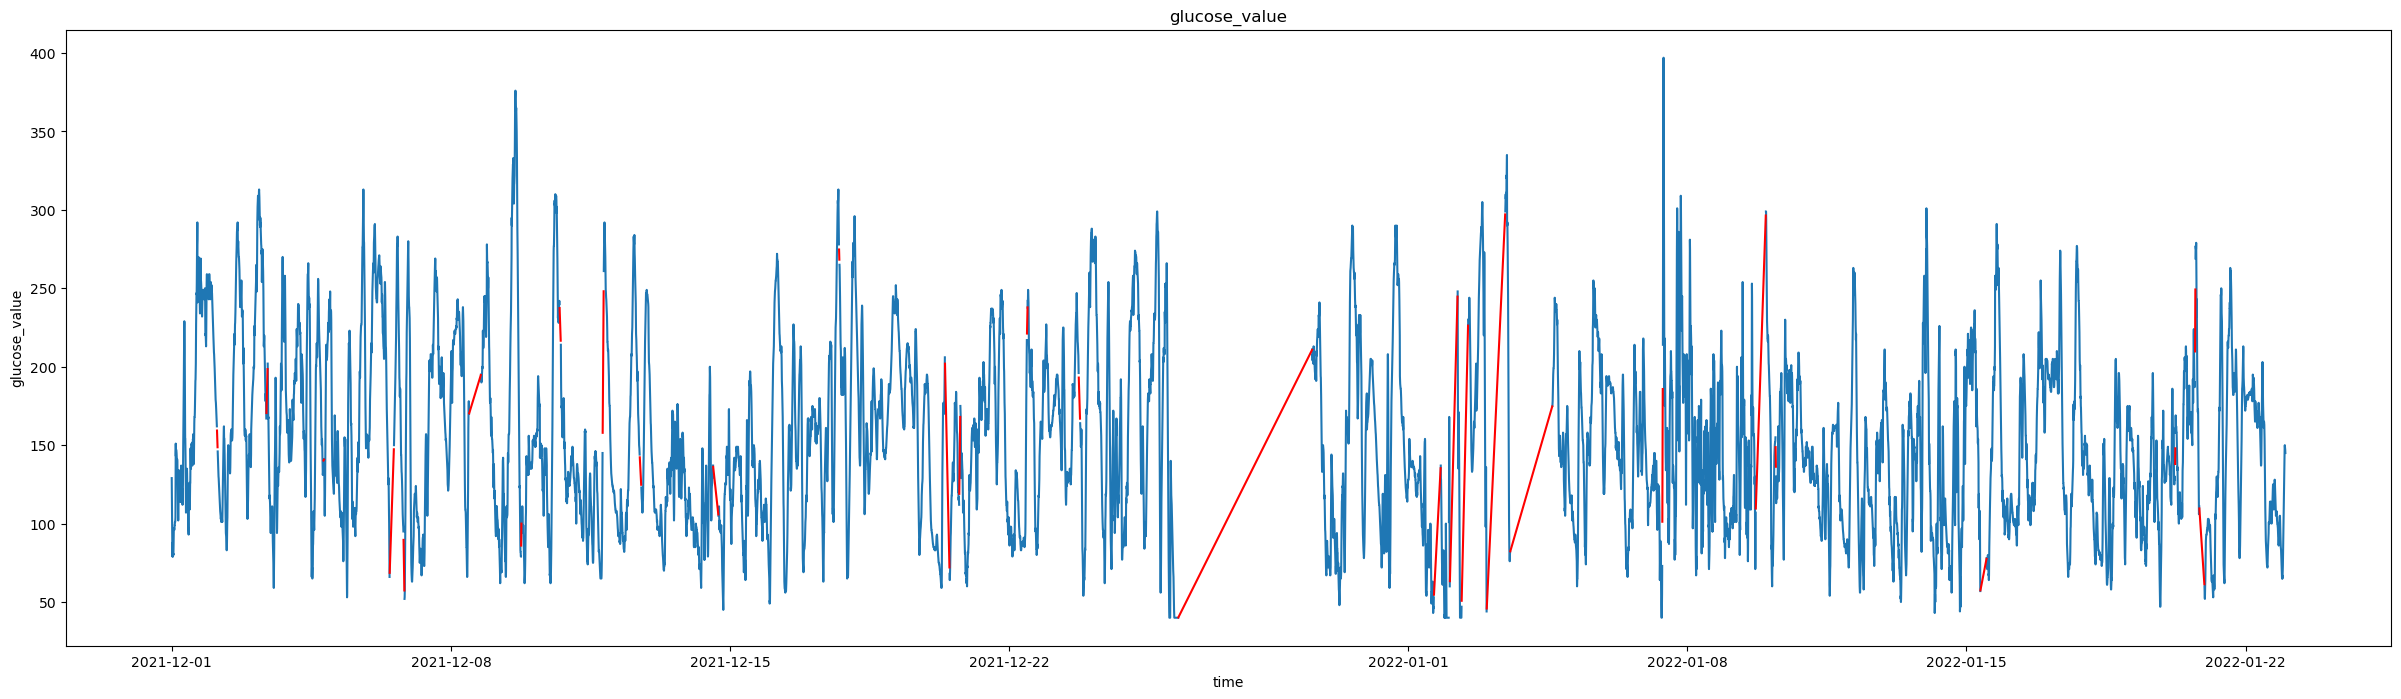

In [347]:
showMissing(df_591, df_nonmiss_591, 'glucose_value')

In [427]:
df_nonmiss_591.to_csv('processed data/GAN/591.csv', index=False)

In [445]:
df_nonmiss_591 = pd.read_csv('processed data/GAN/591.csv')

results from original data

In [446]:
hyper_591, tir_591, l1_591, l2_591, mean_591, std_591 = getStatistics(df_nonmiss_591)

Hyper: 29.900419287211736
TIR: 65.10744234800838
L1 Hypo: 3.5770440251572326
L2 Hypo: 1.4150943396226416
mean: 150.81682389937106
standard deviation: 56.76569513628668


In [447]:
df_glucose_miss_591 = getMissing(df_591, 'glucose_value')
df_glucose_miss_591[df_glucose_miss_591['duration'] > 12]

start                 end  duration
3  2021-12-06 11:10:00 2021-12-06 13:40:00        31
5  2021-12-08 11:00:00 2021-12-08 18:00:00        85
10 2021-12-14 13:50:00 2021-12-14 16:55:00        38
12 2021-12-20 09:20:00 2021-12-20 12:00:00        33
16 2021-12-26 05:45:00 2021-12-29 14:15:00       967
17 2022-01-01 15:35:00 2022-01-01 19:35:00        49
19 2022-01-02 01:10:00 2022-01-02 05:45:00        56
20 2022-01-02 08:15:00 2022-01-02 12:05:00        47
21 2022-01-02 23:20:00 2022-01-03 10:25:00       134
22 2022-01-03 13:30:00 2022-01-04 14:45:00       304
24 2022-01-09 17:15:00 2022-01-09 23:15:00        73
26 2022-01-15 08:25:00 2022-01-15 12:05:00        45
29 2022-01-20 20:10:00 2022-01-20 23:10:00        37

In [448]:
df_nonmiss_591 = df_nonmiss_591.drop(df_nonmiss_591[('2021-12-26' <= df_nonmiss_591['time']) & (df_nonmiss_591['time'] <= '2021-12-30')].index)
df_nonmiss_591 = df_nonmiss_591.reset_index(drop=True)

In [449]:
df_nonmiss_591.to_csv('processed data/GAN/591_remove.csv', index=False)

In [456]:
df_nonmiss_591 = pd.read_csv('processed data/GAN/591_remove.csv')

results from data where the longest gap is removed

In [451]:
hyper_591, tir_591, l1_591, l2_591, mean_591, std_591 = getStatistics(df_nonmiss_591)

Hyper: 30.640589569160998
TIR: 65.5187074829932
L1 Hypo: 3.160430839002268
L2 Hypo: 0.6802721088435374
mean: 152.8578160430839
standard deviation: 56.57983440256926


# Patient 540

In [186]:
df_glucose_training_540 =  readData('data/training_2/540_training/data_glucose_level.csv')
df_glucose_test_540 =  readData('data/testing_2/540_testing/data_glucose_level.csv')
df_glucose_all_540 = pd.concat([df_glucose_training_540, df_glucose_test_540])
df_glucose_all_540 = df_glucose_all_540.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_540['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_540['ts'].iloc[-1]))

df_meal_training_540 =  readData('data/training_2/540_training/data_meal.csv')
df_meal_test_540 =  readData('data/testing_2/540_testing/data_meal.csv')
df_meal_all_540 = pd.concat([df_meal_training_540, df_meal_test_540])
df_meal_all_540 = df_meal_all_540.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_540['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_540['ts'].iloc[-1]))

The glucose data is recorded from 19-05-2027 11:36:29
The glucose data ends at 14-07-2027 15:25:40
The meal data is recorded from 22-05-2027 09:45:00
The meal data ends at 12-07-2027 21:15:00


In [187]:
len(df_meal_all_540)

100

In [47]:
date_new_540 = pd.date_range(start=datetime(2027, 5, 23, hour=0, minute=0), end=datetime(2027, 7, 12, hour=0, minute=0), freq='5min')
df_date_new_540 = pd.DataFrame(date_new_540, columns=['time'])

In [48]:
df_glucose_540, glucose_value_540 = dataSynchronize(df_glucose_all_540, df_date_new_540, '2027-5-22 23:55:00')

In [49]:
df_540 = pd.DataFrame(list(zip(date_new_540, glucose_value_540)), columns=['time', 'glucose_value'])

In [51]:
df_540.to_csv('processed data/Imputation/540.csv', index=False)

# Patient 544

In [188]:
df_glucose_training_544 =  readData('data/training_2/544_training/data_glucose_level.csv')
df_glucose_test_544 =  readData('data/testing_2/544_testing/data_glucose_level.csv')
df_glucose_all_544 = pd.concat([df_glucose_training_544, df_glucose_test_544])
df_glucose_all_544 = df_glucose_all_544.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_544['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_544['ts'].iloc[-1]))

df_meal_training_544 =  readData('data/training_2/544_training/data_meal.csv')
df_meal_test_544 =  readData('data/testing_2/544_testing/data_meal.csv')
df_meal_all_544 = pd.concat([df_meal_training_544, df_meal_test_544])
df_meal_all_544 = df_meal_all_544.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_544['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_544['ts'].iloc[-1]))

The glucose data is recorded from 11-05-2027 00:02:00
The glucose data ends at 04-07-2027 21:17:00
The meal data is recorded from 11-05-2027 11:25:00
The meal data ends at 04-07-2027 17:47:00


In [189]:
len(df_meal_all_544)

197

In [56]:
date_new_544 = pd.date_range(start=datetime(2027, 5, 12, hour=0, minute=0), end=datetime(2027, 7, 4, hour=0, minute=0), freq='5min')
df_date_new_544 = pd.DataFrame(date_new_544, columns=['time'])

In [57]:
df_glucose_544, glucose_value_544 = dataSynchronize(df_glucose_all_544, df_date_new_544, '2027-5-11 23:55:00')

In [58]:
df_544 = pd.DataFrame(list(zip(date_new_544, glucose_value_544)), columns=['time', 'glucose_value'])

In [60]:
df_544.to_csv('processed data/Imputation/544.csv', index=False)

# Patient 552

In [190]:
df_glucose_training_552 =  readData('data/training_2/552_training/data_glucose_level.csv')
df_glucose_test_552 =  readData('data/testing_2/552_testing/data_glucose_level.csv')
df_glucose_all_552 = pd.concat([df_glucose_training_552, df_glucose_test_552])
df_glucose_all_552 = df_glucose_all_552.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_552['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_552['ts'].iloc[-1]))

df_meal_training_552 =  readData('data/training_2/552_training/data_meal.csv')
df_meal_test_552 =  readData('data/testing_2/552_testing/data_meal.csv')
df_meal_all_552 = pd.concat([df_meal_training_552, df_meal_test_552])
df_meal_all_552 = df_meal_all_552.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_552['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_552['ts'].iloc[-1]))

The glucose data is recorded from 16-04-2025 11:17:05
The glucose data ends at 07-06-2025 17:09:51
The meal data is recorded from 16-04-2025 18:00:00
The meal data ends at 05-06-2025 13:00:00


In [191]:
len(df_meal_all_552)

99

In [63]:
date_new_552 = pd.date_range(start=datetime(2025, 4, 17, hour=0, minute=0), end=datetime(2025, 6, 5, hour=0, minute=0), freq='5min')
df_date_new_552 = pd.DataFrame(date_new_552, columns=['time'])

In [64]:
df_glucose_552, glucose_value_552 = dataSynchronize(df_glucose_all_552, df_date_new_552, '2025-4-16 23:55:00')

In [65]:
df_552 = pd.DataFrame(list(zip(date_new_552, glucose_value_552)), columns=['time', 'glucose_value'])

In [67]:
df_552.to_csv('processed data/Imputation/552.csv')

# Patient 567 (no meal data in test)

In [71]:
df_glucose_training_567 =  readData('data/training_2/567_training/data_glucose_level.csv')
df_glucose_test_567 =  readData('data/testing_2/567_testing/data_glucose_level.csv')
df_glucose_all_567 = pd.concat([df_glucose_training_567, df_glucose_test_567])
df_glucose_all_567 = df_glucose_all_567.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_567['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_567['ts'].iloc[-1]))

df_meal_training_567 =  readData('data/training_2/567_training/data_meal.csv')
#df_meal_test_567 =  readData('data/testing_2/567_testing/data_meal.csv')
#df_meal_all_567 = pd.concat([df_meal_training_567, df_meal_test_567])
#df_meal_all_567 = df_meal_all_567.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_training_567['ts'][0]))
print('The meal data ends at {}'.format(df_meal_training_567['ts'].iloc[-1]))

The glucose data is recorded from 28-12-2026 00:04:30
The glucose data ends at 22-02-2027 23:12:13
The meal data is recorded from 28-12-2026 12:40:00
The meal data ends at 10-02-2027 08:30:00


In [192]:
len(df_meal_training_567)

32

In [74]:
date_new_567 = pd.date_range(start=datetime(2026, 12, 29, hour=0, minute=0), end=datetime(2027, 2, 23, hour=0, minute=0), freq='5min')
df_date_new_567 = pd.DataFrame(date_new_567, columns=['time'])

In [95]:
len(df_date_new_567)

16129

In [96]:
len(df_glucose_all_567)

13247

In [132]:
(16129-13247)/16129

0.17868435736871474

In [75]:
df_glucose_567, glucose_value_567 = dataSynchronize(df_glucose_all_567, df_date_new_567, '2026-12-28 23:55:00')

IndexError: single positional indexer is out-of-bounds

In [ ]:
df_567 = pd.DataFrame(list(zip(date_new_567, glucose_value_567)), columns=['time', 'glucose_value'])

In [ ]:
df_567

# Patient 584

In [193]:
df_glucose_training_584 =  readData('data/training_2/584_training/data_glucose_level.csv')
df_glucose_test_584 =  readData('data/testing_2/584_testing/data_glucose_level.csv')
df_glucose_all_584 = pd.concat([df_glucose_training_584, df_glucose_test_584])
df_glucose_all_584 = df_glucose_all_584.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_584['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_584['ts'].iloc[-1]))

df_meal_training_584 =  readData('data/training_2/584_training/data_meal.csv')
df_meal_test_584 =  readData('data/testing_2/584_testing/data_meal.csv')
df_meal_all_584 = pd.concat([df_meal_training_584, df_meal_test_584])
df_meal_all_584 = df_meal_all_584.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_584['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_584['ts'].iloc[-1]))

The glucose data is recorded from 14-05-2025 00:03:00
The glucose data ends at 09-07-2025 09:32:00
The meal data is recorded from 15-05-2025 06:30:00
The meal data ends at 08-07-2025 18:27:00


In [194]:
len(df_meal_all_584)

118

In [78]:
date_new_584 = pd.date_range(start=datetime(2025, 5, 16, hour=0, minute=0), end=datetime(2025, 7, 8, hour=0, minute=0), freq='5min')
df_date_new_584 = pd.DataFrame(date_new_584, columns=['time'])

In [79]:
df_glucose_584, glucose_value_584 = dataSynchronize(df_glucose_all_584, df_date_new_584, '2025-5-15 23:55:00')

In [80]:
df_584 = pd.DataFrame(list(zip(date_new_584, glucose_value_584)), columns=['time', 'glucose_value'])

In [82]:
df_584.to_csv('processed data/Imputation/584.csv', index=False)

# Patient 596

In [195]:
df_glucose_training_596 =  readData('data/training_2/596_training/data_glucose_level.csv')
df_glucose_test_596 =  readData('data/testing_2/596_testing/data_glucose_level.csv')
df_glucose_all_596 = pd.concat([df_glucose_training_596, df_glucose_test_596])
df_glucose_all_596 = df_glucose_all_596.reset_index(drop=True)
print('The glucose data is recorded from {}'.format(df_glucose_all_596['ts'][0]))
print('The glucose data ends at {}'.format(df_glucose_all_596['ts'].iloc[-1]))

df_meal_training_596 =  readData('data/training_2/596_training/data_meal.csv')
df_meal_test_596 =  readData('data/testing_2/596_testing/data_meal.csv')
df_meal_all_596 = pd.concat([df_meal_training_596, df_meal_test_596])
df_meal_all_596 = df_meal_all_596.reset_index(drop=True)
print('The meal data is recorded from {}'.format(df_meal_all_596['ts'][0]))
print('The meal data ends at {}'.format(df_meal_all_596['ts'].iloc[-1]))

The glucose data is recorded from 09-04-2027 16:15:00
The glucose data ends at 06-06-2027 10:11:00
The meal data is recorded from 07-04-2027 12:08:00
The meal data ends at 06-06-2027 05:22:00


In [196]:
len(df_meal_all_596)

319

In [89]:
date_new_596 = pd.date_range(start=datetime(2027, 4, 10, hour=0, minute=0), end=datetime(2027, 6, 6, hour=0, minute=0), freq='5min')
df_date_new_596 = pd.DataFrame(date_new_596, columns=['time'])

In [90]:
df_glucose_596, glucose_value_596 = dataSynchronize(df_glucose_all_596, df_date_new_596, '2027-4-9 23:58:00')

In [91]:
df_596 = pd.DataFrame(list(zip(date_new_596, glucose_value_596)), columns=['time', 'glucose_value'])

In [94]:
df_596.to_csv('processed data/Imputation/596.csv', index=False)